In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import copy
import torch
import warnings
from torch_geometric.utils import lexsort
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
''' Global Paramters '''
TTC_BUBBLE_LOW = 0.0
TTC_CIRCLE_COEF_LOW = 1.0
TTC_THRES_LOW = 3.0

TTC_BUBBLE_HIGH = 0.5
TTC_CIRCLE_COEF_HIGH = 1.0
TTC_THRES_HIGH = 7.5


In [3]:
def get_2D_ttc_circles_cuda_batched(
    ego_pos, ego_vel, ego_dim,
    foe_pos, foe_vel, foe_dim,
    buffer_coef=np.sqrt(2),
    bubble=0,
    batch_size=None
):
    """
    Compute Time-To-Collision (TTC) using multiple-circle approximation with CUDA batch processing.
    Prevents CUDA OOM errors by processing in batches.
    
    Args:
        ego_pos: (N, 2) tensor - Ego vehicle positions (x, y).
        ego_vel: (N, 2) tensor - Ego vehicle velocities (Vx, Vy).
        ego_dim: (N, 2) tensor - Ego vehicle dimensions (Length, Width).
        foe_pos: (N, 2) tensor - Foe vehicle positions (x, y).
        foe_vel: (N, 2) tensor - Foe vehicle velocities (Vx, Vy).
        foe_dim: (N, 2) tensor - Foe vehicle dimensions (Length, Width).
        buffer_coef: Scaling factor for safety buffer (default sqrt(2)).
        batch_size: Number of samples per batch (auto-calculated if None).

    Returns:
        ttc: (N,) tensor - Minimum Time-To-Collision values for each vehicle pair.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    buffer_coef=(torch.tensor(buffer_coef, device='cuda'))
    # Move input tensors to the correct device
    ego_pos = ego_pos.to(dtype=torch.float32, device=device)
    ego_vel = ego_vel.to(dtype=torch.float32, device=device)
    ego_dim = ego_dim.to(dtype=torch.float32, device=device)

    foe_pos = foe_pos.to(dtype=torch.float32, device=device)
    foe_vel = foe_vel.to(dtype=torch.float32, device=device)
    foe_dim = foe_dim.to(dtype=torch.float32, device=device)

    N = ego_pos.shape[0]

    # Auto-adjust batch size if not provided
    if batch_size is None:
        batch_size = min(500000, N)  # Default: 500K samples per batch
        batch_size = max(N, 1)

    num_batches = (N + batch_size - 1) // batch_size  # Compute number of batches
    ttc_results = torch.empty(N, device=device, dtype=torch.float32)  # Allocate space

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, N)

        # Slice batch
        ego_pos_batch = ego_pos[start_idx:end_idx]
        ego_vel_batch = ego_vel[start_idx:end_idx]
        ego_dim_batch = ego_dim[start_idx:end_idx]

        foe_pos_batch = foe_pos[start_idx:end_idx]
        foe_vel_batch = foe_vel[start_idx:end_idx]
        foe_dim_batch = foe_dim[start_idx:end_idx]

        # Compute TTC for batch
        ttc_batch = get_2D_ttc_circles_cuda(
            ego_pos_batch, ego_vel_batch, ego_dim_batch,
            foe_pos_batch, foe_vel_batch, foe_dim_batch,
            buffer_coef, bubble=bubble
        )

        # Store results
        ttc_results[start_idx:end_idx] = ttc_batch

    return ttc_results


def get_approximate_circles_cuda(pos, dim, device="cuda"):
    """
    Approximates a rectangular vehicle as a series of circles along its length.
    Returns a tensor of shape (N, max_circles, 2) containing circle centers.
    """
    x, y = pos[:, 0], pos[:, 1]
    L, W = dim[:, 0], dim[:, 1]

    # Number of circles (at least 1, up to L/W)
    num_circles = torch.ceil(L / W).to(torch.int32)

    max_circles = num_circles.max().item()

    # Compute x positions for circles
    start_x = x - L / 2 + W / 2
    end_x = x + L / 2 - W / 2
    step = (end_x - start_x) / (num_circles - 1).clamp(min=1)

    # Generate indices for evenly spaced circles
    indices = torch.arange(max_circles, device=device).unsqueeze(0)
    valid_mask = indices < num_circles.unsqueeze(1)

    # Compute circle positions
    x_positions = start_x.unsqueeze(1) + indices * step.unsqueeze(1)  # Shape: (N, max_circles)
    y_positions = y.unsqueeze(1).expand(-1, max_circles).clone()  # Keep y constant

    # Mask invalid circles
    x_positions[~valid_mask] = torch.nan
    y_positions[~valid_mask] = torch.nan

    return torch.stack([x_positions, y_positions], dim=-1)  # Shape: (N, max_circles, 2)

def get_2D_ttc_circles_cuda(
    ego_pos, ego_vel, ego_dim,
    foe_pos, foe_vel, foe_dim,
    buffer_coef=torch.sqrt(torch.tensor(2.0, device='cuda')),
    bubble=0
):
    """
    Compute Time-To-Collision (TTC) between vehicles approximated as multiple circles using CUDA acceleration.
    Assumes zero acceleration.
    
    Args:
        ego_pos: (N, 2) tensor - Ego vehicle positions (x, y).
        ego_vel: (N, 2) tensor - Ego vehicle velocities (Vx, Vy).
        ego_dim: (N, 2) tensor - Ego vehicle dimensions (Length, Width).
        foe_pos: (N, 2) tensor - Foe vehicle positions (x, y).
        foe_vel: (N, 2) tensor - Foe vehicle velocities (Vx, Vy).
        foe_dim: (N, 2) tensor - Foe vehicle dimensions (Length, Width).
        buffer_coef: Scaling factor for safety buffer (default sqrt(2)).

    Returns:
        ttc: (N,) tensor - Minimum Time-To-Collision values for each vehicle pair.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Ensure tensors are on GPU
    ego_pos = ego_pos.clone().detach().to(dtype=torch.float32, device=device)
    ego_vel = ego_vel.clone().detach().to(dtype=torch.float32, device=device)
    ego_dim = ego_dim.clone().detach().to(dtype=torch.float32, device=device)

    foe_pos = foe_pos.clone().detach().to(dtype=torch.float32, device=device)
    foe_vel = foe_vel.clone().detach().to(dtype=torch.float32, device=device)
    foe_dim = foe_dim.clone().detach().to(dtype=torch.float32, device=device)

    # Compute circle centers for each vehicle
    ego_circles = get_approximate_circles_cuda(ego_pos, ego_dim, device)  # (N, C, 2)
    foe_circles = get_approximate_circles_cuda(foe_pos, foe_dim, device)  # (N, C, 2)

    # Compute circle radii based on vehicle width
    ego_r = (ego_dim[:, 1] / 2) * buffer_coef + bubble  # Shape: (N,)
    foe_r = (foe_dim[:, 1] / 2) * buffer_coef + bubble # Shape: (N,)
    total_r = ego_r.unsqueeze(1).unsqueeze(1) + foe_r.unsqueeze(1).unsqueeze(1)  # (N, 1, 1)

    # Compute all pairwise circle distances
    ego_exp = ego_circles.unsqueeze(2)  # (N, C, 1, 2)
    foe_exp = foe_circles.unsqueeze(1)  # (N, 1, C, 2)

    rel_pos = ego_exp - foe_exp  # Shape: (N, C, C, 2)
    rel_vel = ego_vel.unsqueeze(1).unsqueeze(1) - foe_vel.unsqueeze(1).unsqueeze(1)  # (N, 1, 1, 2)

    # Compute quadratic coefficients
    A = (rel_vel[..., 0]**2 + rel_vel[..., 1]**2)  # (N, C, C)
    B = 2 * (rel_pos[..., 0] * rel_vel[..., 0] + rel_pos[..., 1] * rel_vel[..., 1])  # (N, C, C)
    C = (rel_pos[..., 0]**2 + rel_pos[..., 1]**2 - total_r**2)  # (N, C, C)

    # Compute discriminant
    discriminant = B**2 - 4 * A * C
    # valid_mask = discriminant >= 0  # Valid solutions where discriminant is non-negative

    # sqrt_disc = torch.sqrt(torch.clamp(discriminant, min=0))  # Avoid NaNs

    sqrt_disc = torch.sqrt(discriminant)
    t1 = (-B + sqrt_disc) / (2 * A) 
    t2 = (-B - sqrt_disc) / (2 * A) 

    # Find the smallest positive TTC
    t1[t1 < 0] = float('inf')
    t2[t2 < 0] = float('inf')

    ttc = torch.min(t1, t2)  # Minimum positive solution for each circle pair

    # overlap mask 
    overlap_mask = C < 0
    ttc[overlap_mask] = 0
 
    # Handle invalid cases correctly
    ttc[torch.isnan(ttc)] = float('inf')  # Replace NaNs
    
    min_ttc = torch.amin(ttc, dim=(1, 2))  # Min over all circle interactions

    # Mask invalid results
    min_ttc = torch.clamp(min_ttc, max=1e9)  # Large value for "no collision"

    return min_ttc

In [4]:
def get_highd_interaction_pairs(data, batch_size=512, interactionList=['precedingId', 'leftPrecedingId', 'leftAlongsideId', 'rightPrecedingId', 'rightAlongsideId'], return_original_indices=False, include_relative_position=False):
    # interactionList = ['precedingId', 'followingId', 'leftPrecedingId', 'leftAlongsideId', 'leftFollowingId', 'rightPrecedingId', 'rightPrecedingId', 'rightAlongsideId', 'rightFollowingId']
    unique_frames = data['frame'].unique()
    batched_frames = [unique_frames[i:i+batch_size] for i in range(0, len(unique_frames), batch_size)]
    num_roles = len(interactionList)
    # outer_indices = tracks.index.to_numpy()
    Egos = []
    Foes = []
    Roles = []
    Original_indices = []
    # Process each batch
    for batch in batched_frames:
        batch_data = data[data['frame'].isin(batch)]
        # Process batch_data...
        surrs = torch.tensor(batch_data[interactionList].values, device='cuda', dtype=torch.int64)
        # Assuming tracks_tensor, frames, ids, and surrs are already defined
        frames = torch.tensor(batch_data['frame'].values, device='cuda', dtype=torch.int64)
        ids = torch.tensor(batch_data['id'].values, device='cuda', dtype=torch.int64)
        # Initialize the result tensor
        n = len(batch_data)
        s = torch.zeros((n,n), dtype=torch.float32)

        # Expand frames and ids for broadcasting
        frame_match = frames.unsqueeze(0) == frames.unsqueeze(1)  # Pairwise frame equality
        id_match = ids.unsqueeze(0).unsqueeze(2) == surrs.unsqueeze(1)  # Match ids with surrs

        # Combine the conditions
        matches = frame_match.unsqueeze(2) & id_match  # Shape: (num_tracks, num_tracks, max_surrs)

        # Reduce along the last dimension (surrs axis) to get a final match matrix
        # s = matches.any(dim=2).to(torch.float32)
        # ego_indices, foe_indices = torch.where(s)
        ego_indices, foe_indices, role_indices = torch.where(matches)
        
        tracks_tensor = torch.tensor(batch_data.values, device='cuda')
        egos = tracks_tensor[ego_indices]
        foes = tracks_tensor[foe_indices]

        Egos.append(egos)
        Foes.append(foes)
        Original_indices.append(list(batch_data.iloc[ego_indices.cpu()].index))

        # One-hot encode the role indices
        role_one_hot = torch.nn.functional.one_hot(role_indices, num_classes=num_roles).to(torch.float32)
        Roles.append(role_one_hot)
            
    ego_data = torch.vstack(Egos)
    foe_data = torch.vstack(Foes)
    position_data = torch.vstack(Roles)
    interaction_indices = np.concatenate(Original_indices)

    outputs = [ego_data, foe_data]
    if return_original_indices:
        outputs.append(interaction_indices)
    if include_relative_position:
        outputs.append(position_data)
    return outputs


In [5]:
def prepare_data_per_recording_2d(recording_id, distillframeinterval=5, lanechangewindow=25):
    tracks = pd.read_csv(f"E:/Data/highd-dataset-v1.0/data/{recording_id:02}_tracks.csv")
    distilled_frames = np.arange(tracks.frame.min(), tracks.frame.max(), distillframeinterval)
    distilled_tracks = tracks[tracks.frame.isin(distilled_frames)]
    # check if lane change will happen
    Pre_LC_L = np.zeros(len(distilled_tracks), dtype=bool)
    Pos_LC_L = np.zeros(len(distilled_tracks), dtype=bool)
    Pre_LC_R = np.zeros(len(distilled_tracks), dtype=bool)
    Pos_LC_R = np.zeros(len(distilled_tracks), dtype=bool)
    lanechangewindowframes = int(lanechangewindow / distillframeinterval)
    # get the direction indicator
    veh_mean_speed = distilled_tracks.groupby('id').xVelocity.transform('mean').values
    dir = (veh_mean_speed / np.abs(veh_mean_speed)).astype('int')
    distilled_tracks.loc[:,'_dir'] = dir
    distilled_tracks.loc[:,'_x'] = distilled_tracks.x + 0.5*distilled_tracks.width
    distilled_tracks.loc[:,'_y'] = distilled_tracks.y + 0.5*distilled_tracks.height

    # check if lane change happens
    for dt in range(1, lanechangewindowframes+1):
        pre_left_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
        pos_left_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
        pre_right_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
        pos_right_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
        upper_mask = distilled_tracks._dir < 0
        lower_mask = distilled_tracks._dir > 0
        # differentiate left or right lane change
        left_lanechange_mask_upper = upper_mask[dt:] & (distilled_tracks.laneId.values[dt:] > distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt])
        right_lanechange_mask_upper = upper_mask[dt:] & (distilled_tracks.laneId.values[dt:] < distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt]) 
        left_lanechange_mask_lower = lower_mask[dt:] & (distilled_tracks.laneId.values[dt:] < distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt])
        right_lanechange_mask_lower = lower_mask[dt:] & (distilled_tracks.laneId.values[dt:] > distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt]) 
        left_lanechange_mask = left_lanechange_mask_upper | left_lanechange_mask_lower
        right_lanechange_mask = right_lanechange_mask_upper | right_lanechange_mask_lower
        # get lc indicators
        pre_left_lc_mask[:-dt] = left_lanechange_mask
        pos_left_lc_mask[dt:] = left_lanechange_mask
        Pre_LC_L += pre_left_lc_mask
        Pos_LC_L += pos_left_lc_mask

        pre_right_lc_mask[:-dt] = right_lanechange_mask
        pos_right_lc_mask[dt:] = right_lanechange_mask
        Pre_LC_R += pre_right_lc_mask
        Pos_LC_R += pos_right_lc_mask

    # get the lane changing indicator
    distilled_tracks.loc[:,'preLeftLaneChange'] = Pre_LC_L.astype(int)
    distilled_tracks.loc[:,'posLeftLaneChange'] = Pos_LC_L.astype(int)
    distilled_tracks.loc[:,'preRightLaneChange'] = Pre_LC_R.astype(int)
    distilled_tracks.loc[:,'posRightLaneChange'] = Pos_LC_R.astype(int)

    def count_in_range(x_array, r=50):
        # Create a 2D difference matrix (each element |x_i - x_j|)
        diff_matrix = np.abs(x_array[:, None] - x_array[None, :])
        # For each row, count how many differences are <= r.
        return (diff_matrix <= r).sum(axis=1)

    # Apply the function for each frame using groupby-transform:
    vehicle_counts_nearby = distilled_tracks.groupby(["frame","_dir"])["_x"].transform(lambda s: count_in_range(s.values, r=1e8))
    # Get segment length
    segment_length = distilled_tracks.x.max() - distilled_tracks.x.min()
    neighbor_nlanes = distilled_tracks.groupby("_dir").laneId.transform('nunique').values
    # get nearby densities
    neighbor_densities = vehicle_counts_nearby / segment_length / neighbor_nlanes * 1000

    def compute_mean_velocity_for_group(group, r=5):
        # Get arrays for x positions and xVelocity
        x_array = group["x"].values
        vel_array = group["xVelocity"].values
        
        # Compute pairwise absolute differences in x positions via broadcasting
        diff_matrix = np.abs(x_array[:, None] - x_array[None, :])
        
        # Boolean mask: True when difference is within r
        in_range_mask = diff_matrix <= r
        
        # For each row, compute the mean xVelocity of vehicles in range
        mean_vel = (in_range_mask * vel_array[None, :]).sum(axis=1) / in_range_mask.sum(axis=1)
        return mean_vel

    def compute_mean_velocity_for_all(df, r=5):
        """
        Compute, for each row in df, the mean of xVelocity for nearby vehicles (|x_i - x|<=r) in the same frame.
        Returns a Series with the same index as df.
        """
        # Group by frame; each group contains vehicles in that frame.
        # For each group, compute mean velocities and return a Series with the same index as the group.
        grouped_series = df.groupby(["frame","_dir"], group_keys=False).apply(
            lambda group: pd.Series(compute_mean_velocity_for_group(group, r), index=group.index)
        )
        # Reindex to ensure the order matches df exactly
        return grouped_series.reindex(df.index)

    # Compute the mean xVelocity for nearby vehicles for each row,
    # ensuring that the output Series has the same order as df.
    mean_vel_series = compute_mean_velocity_for_all(distilled_tracks, r=1e8)

    distilled_tracks['localVelocity'] = mean_vel_series.abs().values
    distilled_tracks['localDensity'] = neighbor_densities

    # ego data -- the following vehicle data
    # foe data -- the leading vehicle data
    ego_, foe_ = get_highd_interaction_pairs(distilled_tracks, batch_size=64)
    (frame_ids, ego_ids, ego_xs, ego_ys, ego_length, ego_width, ego_xVel, ego_yVel, ego_xAccel, ego_yAccel) = ego_[:,0:10].split(1, dim=1)
    (frame_ids, foe_ids, foe_xs, foe_ys, foe_length, foe_width, foe_xVel, foe_yVel, foe_xAccel, foe_yAccel) = foe_[:,0:10].split(1, dim=1)

    ego_pos = torch.cat([ego_xs+0.5*ego_length, ego_ys+0.5*ego_width], dim=1)
    ego_vel = torch.cat([ego_xVel, ego_yVel], dim=1)
    ego_accel = torch.cat([ego_xAccel, ego_yAccel], dim=1)
    ego_dim = torch.cat([ego_length, ego_width], dim=1)

    foe_pos = torch.cat([foe_xs+0.5*foe_length, foe_ys+0.5*foe_width], dim=1)
    foe_vel = torch.cat([foe_xVel, foe_yVel], dim=1)
    foe_accel = torch.cat([foe_xAccel, foe_yAccel], dim=1)
    foe_dim = torch.cat([foe_length, foe_width], dim=1)

    ttc_low = get_2D_ttc_circles_cuda_batched(ego_pos, ego_vel, ego_dim, foe_pos, foe_vel, foe_dim, buffer_coef=TTC_CIRCLE_COEF_LOW, bubble=TTC_BUBBLE_LOW) 
    ttc_high = get_2D_ttc_circles_cuda_batched(ego_pos, ego_vel, ego_dim, foe_pos, foe_vel, foe_dim, buffer_coef=TTC_CIRCLE_COEF_LOW, bubble=TTC_BUBBLE_HIGH)  

    ego_data = pd.DataFrame(ego_.cpu().numpy(), columns=distilled_tracks.columns)
    foe_data = pd.DataFrame(foe_.cpu().numpy(), columns=distilled_tracks.columns)

    del ego_, foe_

    # we need these variables
    ego_vel = ego_data.xVelocity.abs().values
    foe_vel = foe_data.xVelocity.abs().values

    ego_accel = ego_data.xAcceleration.values * ego_data._dir.values
    foe_accel = foe_data.xAcceleration.values * foe_data._dir.values

    ego_pre_leftLc = ego_data.preLeftLaneChange.values
    ego_pos_leftLc = ego_data.posLeftLaneChange.values
    ego_pre_rightLc = ego_data.preRightLaneChange.values
    ego_pos_rightLc = ego_data.posRightLaneChange.values
    foe_pre_leftLc = foe_data.preLeftLaneChange.values
    foe_pos_leftLc = foe_data.posLeftLaneChange.values
    foe_pre_rightLc = foe_data.preRightLaneChange.values
    foe_pos_rightLc = foe_data.posRightLaneChange.values

    ego_length = ego_data.width.values
    foe_length = foe_data.width.values

    original_ttc = copy.deepcopy(ego_data.ttc.values)
    original_ttc[original_ttc <=0] = np.inf

    ego_localspeed = ego_data.localVelocity.values
    foe_localspeed = foe_data.localVelocity.values

    ego_localdensity = ego_data.localDensity.values
    foe_localdensity = foe_data.localDensity.values

    recordingIds = np.full(len(ego_data), recording_id)

    egoIds = ego_data.id.values
    foeIds = foe_data.id.values

    frameIds = ego_data.frame.values

    dataframe = pd.DataFrame(data={
        'ego_vel': ego_vel,
        'foe_vel': foe_vel,
        'ego_accel': ego_accel,
        'foe_accel': foe_accel,
        'ego_pre_left_lc': ego_pre_leftLc,
        'foe_pre_left_lc': foe_pre_leftLc,
        'ego_pos_left_lc': ego_pos_leftLc,
        'foe_pos_left_lc': foe_pos_leftLc,
        'ego_pre_right_lc': ego_pre_rightLc,
        'foe_pre_right_lc': foe_pre_rightLc,
        'ego_pos_right_lc': ego_pos_rightLc,
        'foe_pos_right_lc': foe_pos_rightLc,
        'ego_local_speed': ego_localspeed,
        'foe_local_speed': foe_localspeed,
        'ego_local_density': ego_localdensity,
        'foe_local_density': foe_localdensity,
        'ego_length': ego_length,
        'foe_length': foe_length,
        'recording_id': recordingIds,
        'ego_id': egoIds,
        'foe_id': foeIds,
        'frame': frameIds,
        'dir': ego_data._dir.values,
        'ttc_low': ttc_low.cpu().numpy(),
        'ttc_high': ttc_high.cpu().numpy(),
        'ottc': original_ttc,
    })

    return dataframe

In [6]:
def get_2D_ttc_circles_cuda_batched(
    ego_pos, ego_vel, ego_dim,
    foe_pos, foe_vel, foe_dim,
    buffer_coef=1,
    bubble=0,
    batch_size=None
):
    """
    Compute Time-To-Collision (TTC) using multiple-circle approximation with CUDA batch processing.
    Prevents CUDA OOM errors by processing in batches.
    
    Args:
        ego_pos: (N, 2) tensor - Ego vehicle positions (x, y).
        ego_vel: (N, 2) tensor - Ego vehicle velocities (Vx, Vy).
        ego_dim: (N, 2) tensor - Ego vehicle dimensions (Length, Width).
        foe_pos: (N, 2) tensor - Foe vehicle positions (x, y).
        foe_vel: (N, 2) tensor - Foe vehicle velocities (Vx, Vy).
        foe_dim: (N, 2) tensor - Foe vehicle dimensions (Length, Width).
        buffer_coef: Scaling factor for safety buffer (default sqrt(2)).
        batch_size: Number of samples per batch (auto-calculated if None).

    Returns:
        ttc: (N,) tensor - Minimum Time-To-Collision values for each vehicle pair.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    buffer_coef=(torch.tensor(buffer_coef, device='cuda'))
    # Move input tensors to the correct device
    ego_pos = ego_pos.to(dtype=torch.float32, device=device)
    ego_vel = ego_vel.to(dtype=torch.float32, device=device)
    ego_dim = ego_dim.to(dtype=torch.float32, device=device)

    foe_pos = foe_pos.to(dtype=torch.float32, device=device)
    foe_vel = foe_vel.to(dtype=torch.float32, device=device)
    foe_dim = foe_dim.to(dtype=torch.float32, device=device)

    N = ego_pos.shape[0]

    # Auto-adjust batch size if not provided
    if batch_size is None:
        batch_size = min(500000, N)  # Default: 500K samples per batch
        batch_size = max(N, 1)

    num_batches = (N + batch_size - 1) // batch_size  # Compute number of batches
    ttc_results = torch.empty(N, device=device, dtype=torch.float32)  # Allocate space

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, N)

        # Slice batch
        ego_pos_batch = ego_pos[start_idx:end_idx]
        ego_vel_batch = ego_vel[start_idx:end_idx]
        ego_dim_batch = ego_dim[start_idx:end_idx]

        foe_pos_batch = foe_pos[start_idx:end_idx]
        foe_vel_batch = foe_vel[start_idx:end_idx]
        foe_dim_batch = foe_dim[start_idx:end_idx]

        # Compute TTC for batch
        ttc_batch = get_2D_ttc_circles_cuda(
            ego_pos_batch, ego_vel_batch, ego_dim_batch,
            foe_pos_batch, foe_vel_batch, foe_dim_batch,
            buffer_coef, bubble=bubble
        )

        # Store results
        ttc_results[start_idx:end_idx] = ttc_batch

    return ttc_results


def get_approximate_circles_cuda(pos, dim, device="cuda"):
    """
    Approximates a rectangular vehicle as a series of circles along its length.
    Returns a tensor of shape (N, max_circles, 2) containing circle centers.
    """
    x, y = pos[:, 0], pos[:, 1]
    L, W = dim[:, 0], dim[:, 1]

    # Number of circles (at least 1, up to L/W)
    num_circles = torch.ceil(L / W).to(torch.int32)

    max_circles = num_circles.max().item()

    # Compute x positions for circles
    start_x = x - L / 2 + W / 2
    end_x = x + L / 2 - W / 2
    step = (end_x - start_x) / (num_circles - 1).clamp(min=1)

    # Generate indices for evenly spaced circles
    indices = torch.arange(max_circles, device=device).unsqueeze(0)
    valid_mask = indices < num_circles.unsqueeze(1)

    # Compute circle positions
    x_positions = start_x.unsqueeze(1) + indices * step.unsqueeze(1)  # Shape: (N, max_circles)
    y_positions = y.unsqueeze(1).expand(-1, max_circles).clone()  # Keep y constant

    # Mask invalid circles
    x_positions[~valid_mask] = torch.nan
    y_positions[~valid_mask] = torch.nan

    return torch.stack([x_positions, y_positions], dim=-1)  # Shape: (N, max_circles, 2)

def get_2D_ttc_circles_cuda(
    ego_pos, ego_vel, ego_dim,
    foe_pos, foe_vel, foe_dim,
    buffer_coef=1,
    bubble=0
):
    """
    Compute Time-To-Collision (TTC) between vehicles approximated as multiple circles using CUDA acceleration.
    Assumes zero acceleration.
    
    Args:
        ego_pos: (N, 2) tensor - Ego vehicle positions (x, y).
        ego_vel: (N, 2) tensor - Ego vehicle velocities (Vx, Vy).
        ego_dim: (N, 2) tensor - Ego vehicle dimensions (Length, Width).
        foe_pos: (N, 2) tensor - Foe vehicle positions (x, y).
        foe_vel: (N, 2) tensor - Foe vehicle velocities (Vx, Vy).
        foe_dim: (N, 2) tensor - Foe vehicle dimensions (Length, Width).
        buffer_coef: Scaling factor for safety buffer (default sqrt(2)).

    Returns:
        ttc: (N,) tensor - Minimum Time-To-Collision values for each vehicle pair.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Ensure tensors are on GPU
    ego_pos = ego_pos.clone().detach().to(dtype=torch.float32, device=device)
    ego_vel = ego_vel.clone().detach().to(dtype=torch.float32, device=device)
    ego_dim = ego_dim.clone().detach().to(dtype=torch.float32, device=device)

    foe_pos = foe_pos.clone().detach().to(dtype=torch.float32, device=device)
    foe_vel = foe_vel.clone().detach().to(dtype=torch.float32, device=device)
    foe_dim = foe_dim.clone().detach().to(dtype=torch.float32, device=device)

    # Compute circle centers for each vehicle
    ego_circles = get_approximate_circles_cuda(ego_pos, ego_dim, device)  # (N, C, 2)
    foe_circles = get_approximate_circles_cuda(foe_pos, foe_dim, device)  # (N, C, 2)

    # Compute circle radii based on vehicle width
    ego_r = (ego_dim[:, 1] / 2) * buffer_coef + bubble  # Shape: (N,)
    foe_r = (foe_dim[:, 1] / 2) * buffer_coef + bubble # Shape: (N,)
    total_r = ego_r.unsqueeze(1).unsqueeze(1) + foe_r.unsqueeze(1).unsqueeze(1)  # (N, 1, 1)

    # Compute all pairwise circle distances
    ego_exp = ego_circles.unsqueeze(2)  # (N, C, 1, 2)
    foe_exp = foe_circles.unsqueeze(1)  # (N, 1, C, 2)

    rel_pos = ego_exp - foe_exp  # Shape: (N, C, C, 2)
    rel_vel = ego_vel.unsqueeze(1).unsqueeze(1) - foe_vel.unsqueeze(1).unsqueeze(1)  # (N, 1, 1, 2)

    # Compute quadratic coefficients
    A = (rel_vel[..., 0]**2 + rel_vel[..., 1]**2)  # (N, C, C)
    B = 2 * (rel_pos[..., 0] * rel_vel[..., 0] + rel_pos[..., 1] * rel_vel[..., 1])  # (N, C, C)
    C = (rel_pos[..., 0]**2 + rel_pos[..., 1]**2 - total_r**2)  # (N, C, C)

    # Compute discriminant
    discriminant = B**2 - 4 * A * C
    # valid_mask = discriminant >= 0  # Valid solutions where discriminant is non-negative

    # sqrt_disc = torch.sqrt(torch.clamp(discriminant, min=0))  # Avoid NaNs

    sqrt_disc = torch.sqrt(discriminant)
    t1 = (-B + sqrt_disc) / (2 * A) 
    t2 = (-B - sqrt_disc) / (2 * A) 

    # Find the smallest positive TTC
    t1[t1 < 0] = float('inf')
    t2[t2 < 0] = float('inf')

    ttc = torch.min(t1, t2)  # Minimum positive solution for each circle pair

    # overlap mask 
    overlap_mask = C < 0
    ttc[overlap_mask] = 0
 
    # Handle invalid cases correctly
    ttc[torch.isnan(ttc)] = float('inf')  # Replace NaNs
    
    min_ttc = torch.amin(ttc, dim=(1, 2))  # Min over all circle interactions

    # Mask invalid results
    min_ttc = torch.clamp(min_ttc, max=1e9)  # Large value for "no collision"

    return min_ttc

In [7]:
def process_highd_level1(recording_id, distillframeinterval=5, lanechangewindow=25, trafficstatewindow=50):
    tracks = pd.read_csv(f"E:/Data/highd-dataset-v1.0/data/{recording_id:02}_tracks.csv")
    distilled_frames = np.arange(tracks.frame.min(), tracks.frame.max(), distillframeinterval)
    distilled_tracks = tracks[tracks.frame.isin(distilled_frames)]
    # check if lane change will happen
    Pre_LC_L = np.zeros(len(distilled_tracks), dtype=bool)
    Pos_LC_L = np.zeros(len(distilled_tracks), dtype=bool)
    Pre_LC_R = np.zeros(len(distilled_tracks), dtype=bool)
    Pos_LC_R = np.zeros(len(distilled_tracks), dtype=bool)
    lanechangewindowframes = int(lanechangewindow / distillframeinterval)
    # get the direction indicator
    veh_mean_speed = distilled_tracks.groupby('id').xVelocity.transform('mean').values
    dir = (veh_mean_speed / np.abs(veh_mean_speed)).astype('int')
    distilled_tracks.loc[:,'_dir'] = dir
    distilled_tracks.loc[:,'_x'] = distilled_tracks.x + 0.5*distilled_tracks.width
    distilled_tracks.loc[:,'_y'] = distilled_tracks.y + 0.5*distilled_tracks.height

    # check if lane change happens
    upper_mask = distilled_tracks._dir < 0
    lower_mask = distilled_tracks._dir > 0
    pre_left_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
    pos_left_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
    pre_right_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
    pos_right_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
    for dt in range(1, lanechangewindowframes+1):
        # differentiate left or right lane change
        left_lanechange_mask_upper = upper_mask[dt:] & (distilled_tracks.laneId.values[dt:] > distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt])
        right_lanechange_mask_upper = upper_mask[dt:] & (distilled_tracks.laneId.values[dt:] < distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt]) 
        left_lanechange_mask_lower = lower_mask[dt:] & (distilled_tracks.laneId.values[dt:] < distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt])
        right_lanechange_mask_lower = lower_mask[dt:] & (distilled_tracks.laneId.values[dt:] > distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt]) 
        left_lanechange_mask = left_lanechange_mask_upper | left_lanechange_mask_lower
        right_lanechange_mask = right_lanechange_mask_upper | right_lanechange_mask_lower
        # get lc indicators
        pre_left_lc_mask[:-dt] = left_lanechange_mask
        pos_left_lc_mask[dt:] = left_lanechange_mask
        Pre_LC_L += pre_left_lc_mask
        Pos_LC_L += pos_left_lc_mask

        pre_right_lc_mask[:-dt] = right_lanechange_mask
        pos_right_lc_mask[dt:] = right_lanechange_mask
        Pre_LC_R += pre_right_lc_mask
        Pos_LC_R += pos_right_lc_mask

    # get the lane changing indicator
    distilled_tracks.loc[:,'preLeftLaneChange'] = Pre_LC_L.astype(int)
    distilled_tracks.loc[:,'posLeftLaneChange'] = Pos_LC_L.astype(int)
    distilled_tracks.loc[:,'preRightLaneChange'] = Pre_LC_R.astype(int)
    distilled_tracks.loc[:,'posRightLaneChange'] = Pos_LC_R.astype(int)

    def count_in_range(x_array, r=50):
        # Create a 2D difference matrix (each element |x_i - x_j|)
        diff_matrix = np.abs(x_array[:, None] - x_array[None, :])
        # For each row, count how many differences are <= r.
        return (diff_matrix <= r).sum(axis=1)

    # Apply the function for each frame using groupby-transform:
    vehicle_counts_nearby = distilled_tracks.groupby(["frame","_dir"])["_x"].transform(lambda s: count_in_range(s.values, r=1e8))
    # Get segment length
    segment_length = distilled_tracks.x.max() - distilled_tracks.x.min()
    neighbor_nlanes = distilled_tracks.groupby("_dir").laneId.transform('nunique').values
    # get nearby densities
    neighbor_densities = vehicle_counts_nearby / segment_length / neighbor_nlanes * 1000

    def compute_mean_velocity_for_group(group, r=5):
        # Get arrays for x positions and xVelocity
        x_array = group["x"].values
        vel_array = group["xVelocity"].values
        
        # Compute pairwise absolute differences in x positions via broadcasting
        diff_matrix = np.abs(x_array[:, None] - x_array[None, :])
        
        # Boolean mask: True when difference is within r
        in_range_mask = diff_matrix <= r
        
        # For each row, compute the mean xVelocity of vehicles in range
        mean_vel = (in_range_mask * vel_array[None, :]).sum(axis=1) / in_range_mask.sum(axis=1)
        return mean_vel

    def compute_mean_velocity_for_all(df, r=5):
        """
        Compute, for each row in df, the mean of xVelocity for nearby vehicles (|x_i - x|<=r) in the same frame.
        Returns a Series with the same index as df.
        """
        # Group by frame; each group contains vehicles in that frame.
        # For each group, compute mean velocities and return a Series with the same index as the group.
        grouped_series = df.groupby(["frame","_dir"], group_keys=False).apply(
            lambda group: pd.Series(compute_mean_velocity_for_group(group, r), index=group.index)
        )
        # Reindex to ensure the order matches df exactly
        return grouped_series.reindex(df.index)

    # Compute the mean xVelocity for nearby vehicles for each row,
    # ensuring that the output Series has the same order as df.
    mean_vel_series = compute_mean_velocity_for_all(distilled_tracks, r=1e8)

    distilled_tracks['localVelocity'] = mean_vel_series.abs().values
    distilled_tracks['localDensity'] = neighbor_densities
    distilled_tracks['localLanesNum'] = neighbor_nlanes

    # check if traffic state is changing
    shockwave_front_mask = np.zeros(distilled_tracks.frame.nunique(), dtype=bool)
    shockwave_tail_mask = np.zeros(distilled_tracks.frame.nunique(), dtype=bool)

    for t in range(1, trafficstatewindow+1):
        cur_density = distilled_tracks.groupby('frame').localDensity.mean().values[:-t]
        fut_density = distilled_tracks.groupby('frame').localDensity.mean().values[t:]
        shockwave_front_mask[:-t] += cur_density - fut_density < -5
        shockwave_tail_mask[:-t] += cur_density - fut_density > 5

    distilled_tracks['shockwaveFront'] = shockwave_front_mask[distilled_tracks['frame'].factorize()[0]].astype(int)
    distilled_tracks['shockwaveTail'] = shockwave_tail_mask[distilled_tracks['frame'].factorize()[0]].astype(int)

    return distilled_tracks


In [8]:
def get_subjective_risk(dx, dy, vx, gx_p=[1.2925, 1.0621, -3.7051e-2, 5.1053e-4], bx=3.2589, gy=1.4310, by=4.9956, device='cuda'):
    gx_p = torch.tensor(gx_p, device=device)
    gx = torch.zeros_like(dx, device=device)
    for i in range(len(gx_p)):
        gx +=  vx**i *gx_p[i]  
    s = torch.abs(dx/gx) ** bx + torch.abs(dy/gy) ** by
    risk = torch.exp( -s )
    return risk

In [9]:
def add_risk_to_data(data, batch_size=32):
    interact_dir = ['precedingId', 'followingId','leftPrecedingId','leftAlongsideId','leftFollowingId','rightPrecedingId','rightAlongsideId','rightFollowingId']
    processed_data = copy.deepcopy(data)

    for _dir in interact_dir:
        ego_, foe_, idx_ = get_highd_interaction_pairs(data, batch_size=batch_size, interactionList=[_dir], return_original_indices=True)
        (frame_ids, ego_ids, ego_xs, ego_ys, ego_length, ego_width, ego_xVel, ego_yVel, ego_xAccel, ego_yAccel) = ego_[:,0:10].split(1, dim=1)
        (frame_ids, foe_ids, foe_xs, foe_ys, foe_length, foe_width, foe_xVel, foe_yVel, foe_xAccel, foe_yAccel) = foe_[:,0:10].split(1, dim=1)

        ego_pos = torch.cat([ego_xs+0.5*ego_length, ego_ys+0.5*ego_width], dim=1)
        ego_vel = torch.cat([ego_xVel, ego_yVel], dim=1)
        ego_accel = torch.cat([ego_xAccel, ego_yAccel], dim=1)
        ego_dim = torch.cat([ego_length, ego_width], dim=1)

        foe_pos = torch.cat([foe_xs+0.5*foe_length, foe_ys+0.5*foe_width], dim=1)
        foe_vel = torch.cat([foe_xVel, foe_yVel], dim=1)
        foe_accel = torch.cat([foe_xAccel, foe_yAccel], dim=1)
        foe_dim = torch.cat([foe_length, foe_width], dim=1)

        rel_pos = ego_pos - foe_pos
        _dx = torch.clamp_min(torch.abs(rel_pos[:,0]) - (ego_dim[:,0]/2 + foe_dim[:,0]/2), 0)
        _dy = torch.clamp_min(torch.abs(rel_pos[:,1]) - (ego_dim[:,1]/2 + foe_dim[:,1]/2), 0)
        _vel = torch.sqrt(ego_vel[:,0]**2 + ego_vel[:,1]**2)

        s_risks = get_subjective_risk(_dx, _dy, _vel)
        risk_col_name = _dir[:-2] + 'SubjectiveRisk'
        processed_data[risk_col_name] = np.zeros(len(data))
        processed_data.loc[idx_, risk_col_name] = s_risks.cpu().numpy()
    return processed_data



In [10]:
def add_ttc_to_data(data, batch_size=64):
    interact_dir = ['precedingId', 'followingId','leftPrecedingId','leftAlongsideId','leftFollowingId','rightPrecedingId','rightAlongsideId','rightFollowingId']
    processed_data = copy.deepcopy(data)

    for _dir in interact_dir:
        ego_, foe_, idx_ = get_highd_interaction_pairs(data, batch_size=batch_size, interactionList=[_dir], return_original_indices=True)
        (frame_ids, ego_ids, ego_xs, ego_ys, ego_length, ego_width, ego_xVel, ego_yVel, ego_xAccel, ego_yAccel) = ego_[:,0:10].split(1, dim=1)
        (frame_ids, foe_ids, foe_xs, foe_ys, foe_length, foe_width, foe_xVel, foe_yVel, foe_xAccel, foe_yAccel) = foe_[:,0:10].split(1, dim=1)

        ego_pos = torch.cat([ego_xs+0.5*ego_length, ego_ys+0.5*ego_width], dim=1)
        ego_vel = torch.cat([ego_xVel, ego_yVel], dim=1)
        ego_accel = torch.cat([ego_xAccel, ego_yAccel], dim=1)
        ego_dim = torch.cat([ego_length, ego_width], dim=1)

        foe_pos = torch.cat([foe_xs+0.5*foe_length, foe_ys+0.5*foe_width], dim=1)
        foe_vel = torch.cat([foe_xVel, foe_yVel], dim=1)
        foe_accel = torch.cat([foe_xAccel, foe_yAccel], dim=1)
        foe_dim = torch.cat([foe_length, foe_width], dim=1)

        ttc_low = get_2D_ttc_circles_cuda_batched(ego_pos, ego_vel, ego_dim, foe_pos, foe_vel, foe_dim, buffer_coef=TTC_CIRCLE_COEF_LOW, bubble=TTC_BUBBLE_LOW) 
        ttc_high = get_2D_ttc_circles_cuda_batched(ego_pos, ego_vel, ego_dim, foe_pos, foe_vel, foe_dim, buffer_coef=TTC_CIRCLE_COEF_HIGH, bubble=TTC_BUBBLE_HIGH) 

        risk_col_name_low = _dir[:-2] + 'TTC_Low'
        risk_col_name_high = _dir[:-2] + 'TTC_High'
        processed_data[risk_col_name_low] = np.full(len(data), 1e9)
        processed_data[risk_col_name_high] = np.full(len(data), 1e9)
        processed_data.loc[idx_, risk_col_name_low] = ttc_low.cpu().numpy()
        processed_data.loc[idx_, risk_col_name_high] = ttc_high.cpu().numpy()
    return processed_data


In [11]:
def calculate_ttc(ego_data, foe_data, buffer_coef=1, bubble=0, device='cuda'):
    ego_ = torch.tensor(ego_data.values, device=device)
    foe_ = torch.tensor(foe_data.values, device=device)

    (frame_ids, ego_ids, ego_xs, ego_ys, ego_length, ego_width, ego_xVel, ego_yVel, ego_xAccel, ego_yAccel) = ego_[:,0:10].split(1, dim=1)
    (frame_ids, foe_ids, foe_xs, foe_ys, foe_length, foe_width, foe_xVel, foe_yVel, foe_xAccel, foe_yAccel) = foe_[:,0:10].split(1, dim=1)

    ego_pos = torch.cat([ego_xs+0.5*ego_length, ego_ys+0.5*ego_width], dim=1)
    ego_vel = torch.cat([ego_xVel, ego_yVel], dim=1)
    ego_accel = torch.cat([ego_xAccel, ego_yAccel], dim=1)
    ego_dim = torch.cat([ego_length, ego_width], dim=1)

    foe_pos = torch.cat([foe_xs+0.5*foe_length, foe_ys+0.5*foe_width], dim=1)
    foe_vel = torch.cat([foe_xVel, foe_yVel], dim=1)
    foe_accel = torch.cat([foe_xAccel, foe_yAccel], dim=1)
    foe_dim = torch.cat([foe_length, foe_width], dim=1)

    ttc = get_2D_ttc_circles_cuda_batched(ego_pos, ego_vel, ego_dim, foe_pos, foe_vel, foe_dim, buffer_coef=buffer_coef, bubble=bubble) 

    return ttc.cpu().numpy()

In [12]:
def get_interaction_recording_2d(ego_data, foe_data, recording_id=0, device='cuda'):
    
    ttc_low = calculate_ttc(ego_data, foe_data, TTC_CIRCLE_COEF_LOW, TTC_BUBBLE_LOW, device=device)
    ttc_high = calculate_ttc(ego_data, foe_data, TTC_CIRCLE_COEF_HIGH, TTC_BUBBLE_HIGH, device=device)

    # we need these variables
    ego_vel = ego_data.xVelocity.abs().values
    foe_vel = foe_data.xVelocity.abs().values

    ego_accel = ego_data.xAcceleration.values * ego_data._dir.values
    foe_accel = foe_data.xAcceleration.values * foe_data._dir.values

    ego_pre_leftLc = ego_data.preLeftLaneChange.values
    ego_pos_leftLc = ego_data.posLeftLaneChange.values
    ego_pre_rightLc = ego_data.preRightLaneChange.values
    ego_pos_rightLc = ego_data.posRightLaneChange.values
    foe_pre_leftLc = foe_data.preLeftLaneChange.values
    foe_pos_leftLc = foe_data.posLeftLaneChange.values
    foe_pre_rightLc = foe_data.preRightLaneChange.values
    foe_pos_rightLc = foe_data.posRightLaneChange.values

    ego_length = ego_data.width.values
    foe_length = foe_data.width.values
    ego_subjective_risk = ego_data.vehicleLevelRisk.values
    foe_subjective_risk = foe_data.vehicleLevelRisk.values
    _localspeed = ego_data.localVelocity.values
    _localdensity = ego_data.localDensity.values
    _localSRisk = ego_data.meanVehicleLevelRisk.values
    _localNLanes = ego_data.localLanesNum.values
    _localWaveFront = ego_data.shockwaveFront.values
    _localWaveTail = ego_data.shockwaveTail.values


    recordingIds = np.full(len(ego_data), recording_id)

    egoIds = ego_data.id.values
    foeIds = foe_data.id.values
    frameIds = ego_data.frame.values

    dataframe = pd.DataFrame(data={
        'ego_vel': ego_vel,
        'foe_vel': foe_vel,
        'ego_accel': ego_accel,
        'foe_accel': foe_accel,
        'ego_pre_left_lc': ego_pre_leftLc,
        'foe_pre_left_lc': foe_pre_leftLc,
        'ego_pos_left_lc': ego_pos_leftLc,
        'foe_pos_left_lc': foe_pos_leftLc,
        'ego_pre_right_lc': ego_pre_rightLc,
        'foe_pre_right_lc': foe_pre_rightLc,
        'ego_pos_right_lc': ego_pos_rightLc,
        'foe_pos_right_lc': foe_pos_rightLc,
        'ego_subjective_risk': ego_subjective_risk,
        'foe_subjective_risk': foe_subjective_risk,
        'local_speed': _localspeed,
        'local_density': _localdensity,
        'local_subjective_risk': _localSRisk,
        'local_lane': _localNLanes,
        'local_wave_front': _localWaveFront,
        'local_wave_tail': _localWaveTail,
        'ego_length': ego_length,
        'foe_length': foe_length,
        'recording_id': recordingIds,
        'ego_id': egoIds,
        'foe_id': foeIds,
        'frame': frameIds,
        'dir': ego_data._dir.values,
        'ttc_low': ttc_low,
        'ttc_high': ttc_high,
    })

    cols_position = [col for col in ego_data.columns if col.endswith('Position')]
    dataframe[cols_position] = ego_data[cols_position]

    return dataframe

In [13]:
def get_processing_flow(recordings=range(1,61), distillframeinterval=5, lanechangewindow=25, interactionVehicles=['preceding', 'leftPreceding', 'leftAlongside', 'rightPreceding', 'rightPreceding', 'rightAlongside']):
    Concat_Data = []
    interactionList = [ interaction+'Id' for interaction in interactionVehicles  ]
    interactionPositions = [interaction+'Position' for interaction in interactionVehicles ]
    for recordingId in tqdm(recordings):
        tracks = process_highd_level1(recordingId, distillframeinterval=distillframeinterval, lanechangewindow=lanechangewindow)
        tracks_with_risk = add_risk_to_data(tracks)
        risks_data = tracks_with_risk[['precedingSubjectiveRisk', 'followingSubjectiveRisk', 'leftPrecedingSubjectiveRisk', 'leftAlongsideSubjectiveRisk', 'leftFollowingSubjectiveRisk', 'rightPrecedingSubjectiveRisk','rightAlongsideSubjectiveRisk', 'rightFollowingSubjectiveRisk']].values
        vehicle_level_risks = 1 - np.prod(1-risks_data, axis=1)
        tracks_with_risk['vehicleLevelRisk'] = vehicle_level_risks
        tracks_with_risk['meanVehicleLevelRisk'] = (
            tracks_with_risk.groupby(['frame', '_dir'])['vehicleLevelRisk']
            .transform('mean')
        )
        
        ego_risk_data, foe_risk_data, _indices, position_data = get_highd_interaction_pairs(tracks_with_risk, batch_size=32, interactionList=interactionList, return_original_indices=True, include_relative_position=True)
        df_ego_risk = pd.DataFrame(ego_risk_data.cpu(), columns=tracks_with_risk.columns)
        df_foe_risk = pd.DataFrame(foe_risk_data.cpu(), columns=tracks_with_risk.columns)
        df_ego_risk[interactionPositions] = position_data.cpu().numpy()
        del ego_risk_data, foe_risk_data
        processed_tracks = get_interaction_recording_2d(df_ego_risk, df_foe_risk, recordingId)
        Concat_Data.append(processed_tracks)
    return pd.concat(Concat_Data)


In [14]:
def compute_time_until_next_ttc_below_threshold_vectorized(data, threshold=1.5, batch_size=500):
    """
    Compute the time (frames) until the next occurrence of `TTC < threshold` for each unique 
    ego-foe interaction (defined by ego_id, foe_id, recording_id).

    If the current row already has `TTC < threshold`, return 0.

    Args:
        data: (N, 5) tensor - Columns: [ego_id, foe_id, recording_id, frame_id, ttc]
        threshold: float - TTC threshold (default 1.5 seconds).
        batch_size: int - Number of unique (ego_id, foe_id, recording_id) pairs processed at once.

    Returns:
        time_until_next_ttc_below: (N,) tensor - Time until next TTC < threshold for each row, 
                                              in the original input order.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move data to GPU if available
    data = data.to(device)

    # Save original indices to restore order later
    original_indices = torch.arange(data.shape[0], device=device)

    # Extract columns
    ego_id, foe_id, recording_id, frame_id, ttc = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]

    # ✅ Step 1: Correct Multi-Column Sorting
    # Sorting by (ego_id, foe_id, recording_id, frame_id)
    sorted_indices = lexsort((frame_id, recording_id, foe_id, ego_id))

    # Apply sorting
    ego_id, foe_id, recording_id, frame_id, ttc, original_indices = (
        ego_id[sorted_indices], foe_id[sorted_indices], recording_id[sorted_indices],
        frame_id[sorted_indices], ttc[sorted_indices], original_indices[sorted_indices]
    )

    # ✅ Step 2: Identify Unique (ego_id, foe_id, recording_id) Pairs
    unique_pairs, pair_indices = torch.unique(
        torch.stack([ego_id, foe_id, recording_id], dim=1),
        dim=0, return_inverse=True
    )

    num_pairs = unique_pairs.shape[0]  # Total unique pairs
    num_batches = (num_pairs + batch_size - 1) // batch_size  # Compute number of batches

    # ✅ Step 3: Identify All Frames Where `TTC < threshold`
    below_threshold_mask = ttc < threshold  # Boolean mask where TTC < threshold
    valid_frame_ids = frame_id[below_threshold_mask]  # Frames where `TTC < threshold`
    valid_pair_indices = pair_indices[below_threshold_mask]  # Matching pair indices

    # Initialize the result tensor
    time_until_next_ttc_below = torch.full_like(frame_id, float('inf'), device=device)

    # ✅ Step 4: Process in Batches to Reduce Memory Usage
    for batch_idx in trange(num_batches):
        # Get the current batch of pairs
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_pairs)
        batch_pair_indices = torch.arange(start_idx, end_idx, device=device)

        # Get mask for rows belonging to this batch
        batch_mask = (pair_indices >= start_idx) & (pair_indices < end_idx)

        if batch_mask.sum() == 0:  # Skip if no data in batch
            continue

        # Get the frame_ids of the current batch
        batch_frame_ids = frame_id[batch_mask]

        # Get the valid events that belong to this batch
        batch_valid_mask = (valid_pair_indices >= start_idx) & (valid_pair_indices < end_idx)
        batch_valid_frame_ids = valid_frame_ids[batch_valid_mask]
        batch_valid_pair_indices = valid_pair_indices[batch_valid_mask]

        if batch_valid_frame_ids.numel() == 0:  # Skip empty batches
            continue

        # Compute `valid_frame_ids - frame_id` in a batched, vectorized manner
        all_time_diffs = batch_valid_frame_ids.unsqueeze(0) - batch_frame_ids.unsqueeze(1)  # (batch_size, num_valid_events)
        all_time_diffs[all_time_diffs <= 0] = float('inf')  # Ignore past events  

        # ✅ Step 5: Ensure we only consider valid pairs
        pair_match_mask = pair_indices[batch_mask].unsqueeze(1) == batch_valid_pair_indices.unsqueeze(0)  # Shape: (batch_size, num_valid_events)
        all_time_diffs[~pair_match_mask] = float('inf')  # Mask invalid pairs

        # Compute the minimum valid time difference per row
        min_time_diffs, _ = all_time_diffs.min(dim=1)

        # ✅ Step 6: Assign results back
        time_until_next_ttc_below[batch_mask] = min_time_diffs

    # ✅ Step 7: Post-processing
    # If the row itself is `TTC < threshold`, set time until next to `0`
    time_until_next_ttc_below[below_threshold_mask] = 0

    # If no future `TTC < threshold` exists, set time to `-1`
    time_until_next_ttc_below[time_until_next_ttc_below == float('inf')] = -1

    # ✅ Step 8: Restore Original Order
    restored_order = torch.argsort(original_indices)  # Get indices that map back to the original order
    time_until_next_ttc_below = time_until_next_ttc_below[restored_order]  # Restore order

    return time_until_next_ttc_below

def compute_transitions_vectorized_mode_1(data, thres1=1.5, thres2=3.0, device='cuda'):
    data = torch.tensor(data, device=device)

    ttc1 = compute_time_until_next_ttc_below_threshold_vectorized(data[:,(0,1,2,3,4)], threshold=thres1, batch_size=1000)
    ttc2 = compute_time_until_next_ttc_below_threshold_vectorized(data[:,(0,1,2,3,5)], threshold=thres2, batch_size=1000)

    # Step 1: Extract columns
    ego_id, foe_id, recording_id, frame_id = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

    original_indices = torch.arange(data.shape[0], device=device)
    sorted_indices = lexsort((frame_id, recording_id, foe_id, ego_id))
    
    # Apply sorting
    ego_id, foe_id, recording_id, frame_id, original_indices, ttc1, ttc2 = (
        ego_id[sorted_indices], foe_id[sorted_indices], recording_id[sorted_indices],
        frame_id[sorted_indices], original_indices[sorted_indices], ttc1[sorted_indices], ttc2[sorted_indices]
    )

    # Step 2: Find unique (ego_id, foe_id, recording_id) groups
    unique_pairs, pair_indices = torch.unique(torch.stack([ego_id, foe_id, recording_id], dim=1), dim=0, return_inverse=True)

    states = torch.full_like(ttc1, 3, dtype=torch.int32, device='cuda')  # Default is state 3
    states[ttc2 == 0] = 2  # If TTC < 5, but not < 1.5
    states[ttc1 == 0] = 1  # If TTC < 1.5, override to state 1

    state_changes = (states[1:] != states[:-1])*(pair_indices[1:] == pair_indices[:-1])
    transition_indices = torch.where(state_changes)[0] + 1  # Convert to indices (offset by 1)
    
    first_frames_per_group = torch.full_like(frame_id, float('inf'))  # Initialize with large values
    first_frames_per_group = first_frames_per_group.scatter_reduce_(0, pair_indices, frame_id, reduce="amin")[:len(unique_pairs)]

    first_transition_per_group = torch.full((pair_indices.max() + 1,), torch.iinfo(torch.long).max, dtype=torch.long, device=transition_indices.device)

    # Step 3: Scatter reduce to find the first transition index per group
    first_transition_per_group.scatter_reduce_(0, pair_indices[transition_indices], transition_indices, reduce="amin")

    # Step 4: Compare transition indices with the first transition per group
    first_transition_mask = transition_indices == first_transition_per_group[pair_indices[transition_indices]]

    # Step 5: 
    n_transitions = len(transition_indices)
    transition_from_states = states[transition_indices-1]
    transition_to_states = states[transition_indices]
    transition_start_frames = torch.cat([torch.tensor([0], device=device), frame_id[transition_indices[0:n_transitions-1]]])
    transition_start_frames = transition_start_frames*~first_transition_mask + first_transition_mask*first_frames_per_group[pair_indices[transition_indices]]
    transition_end_frames = frame_id[transition_indices[0:n_transitions]] 

    transitions = torch.stack([ego_id[transition_indices], foe_id[transition_indices], recording_id[transition_indices], transition_start_frames, transition_end_frames, transition_from_states, transition_to_states], dim=1)
    return transitions


In [15]:
# def get_processed_input_start_stop(data, transition, sequence=250, from_state=2, to_state=1, truck_thres=10, accel_thres=0.67, density_norm=50, speed_norm=45, device='cuda', interval=5):
#     transition = transition[ (transition['from']==from_state)&(transition['to']==to_state) ]  if from_state != None and to_state != None else transition # only process certain transitions
#     Tran = torch.tensor(transition.values, device=device)
#     # get ego, foe vehicle class
#     ego_class = np.asarray(data.ego_length.values > truck_thres).astype(int)
#     foe_class = np.asarray(data.foe_length.values > truck_thres).astype(int)
#     # get ego, foe acceleration status
#     ego_accel = np.zeros(len(data))
#     ego_decel = np.zeros(len(data))
#     ego_accel[data.ego_accel > accel_thres] = 1
#     ego_decel[data.ego_accel < -accel_thres] = 1
#     foe_accel = np.zeros(len(data))
#     foe_decel = np.zeros(len(data))
#     foe_accel[data.foe_accel > accel_thres] = 1
#     foe_decel[data.foe_accel < -accel_thres] = 1
#     # get ego, foe lc status
#     ego_pre_left_lc = data.ego_pre_left_lc.values
#     ego_pre_right_lc = data.ego_pre_right_lc.values
#     ego_pos_left_lc = data.ego_pos_left_lc.values
#     ego_pos_right_lc = data.ego_pos_right_lc.values

#     foe_pre_left_lc = data.foe_pre_left_lc.values
#     foe_pre_right_lc = data.foe_pre_right_lc.values
#     foe_pos_left_lc = data.foe_pos_left_lc.values
#     foe_pos_right_lc = data.foe_pos_right_lc.values

#     ego_env_risks = data.local_subjective_risk.values

#     num_lanes = np.asarray(data.local_lane.values >= 3).astype(int)

#     # get ego, foe local density
#     ego_local_density = np.asarray(data.local_density.values > density_norm).astype(int)
#     # get ego, foe local speed
#     ego_local_speed = np.asarray(data.local_speed.values < speed_norm).astype(int)
#     # near a ramp?
#     ramp = np.asarray( (data.recording_id.isin([58,59,60]))&(data.dir==-1) ).astype(int)
#     # get ego id
#     _ego = data.ego_id.values
#     # get foe id
#     _foe = data.foe_id.values
#     # get record
#     _record = data.recording_id.values
#     #
#     # get frame
#     _frame = data.frame.values
#     data = np.array(
#     [
#         ego_pre_left_lc, ego_pre_right_lc, ego_pos_left_lc, ego_pos_right_lc, foe_pre_left_lc, foe_pre_right_lc, foe_pos_left_lc, foe_pos_right_lc, ego_accel, ego_decel, foe_accel, foe_decel, ego_class, foe_class, ego_local_density, ego_local_speed, ego_env_risks, ramp, num_lanes, _ego, _foe, _record, _frame
#     ]
#     ).T
#     # np.nan_to_num(data, 0)
#     data = torch.tensor(data, device=device, dtype=torch.float)

#     _ego = data[:,-4]
#     _foe = data[:,-3]
#     _record = data[:,-2]
#     _frames = data[:,-1]

#     n_features = data.shape[1]
#     n_sequance = int(sequence/interval)
    
#     # get the input data
#     _Data = torch.torch.full((len(Tran), n_sequance, n_features), float('nan'), device='cuda')
#     for m in trange(len(Tran)):
#         ego, foe, record, start, end, _from, to = Tran[m]
#         _start = torch.max(end - (n_sequance-1)*interval, start)
#         mask = ((_frames.unsqueeze(1) >= (_start)) & (_frames.unsqueeze(1) <= end) & (_ego.unsqueeze(1)==ego) &  (_foe.unsqueeze(1)==foe) & (_record.unsqueeze(1)==record)   ).any(dim=1)
#         indices = (-(end-_frames[mask])/ interval ).to(torch.int) - 1
#         _Data[m][indices] = data[mask]
#     return _Data

# def get_start_stop_input_transitions(data, _transition, window=250, sequence=250, from_state=None, to_state=None, truck_thres=10, accel_thres=0.67, density_norm=50, speed_norm=45, device='cuda'):
#     # get intermediate input
#     _input = get_processed_input_start_stop(data, _transition, sequence=sequence, from_state=from_state, to_state=to_state, truck_thres=truck_thres, accel_thres=accel_thres, density_norm=density_norm, speed_norm=speed_norm, device=device)
#     valid_mask = (_transition.end - _transition.start) < sequence
#     transition = _transition[valid_mask]
#     _input = _input[valid_mask]
#     # process the input data
#     ChunkList = []
#     print ( "-- Generating start stop data -- ")
#     for i in trange(_input.shape[0]):
#         row = _input[i]
#         dur = transition.iloc[i]
#         transition_mask = ~torch.isnan(row).any(dim=1)
#         transition_data = row[transition_mask]
#         transition_frames = transition_data[:,-1]
#         group_ids = ((transition_frames - transition_frames[0]) // window).long()
#         max_g = max(group_ids)
#         group_counts = torch.bincount(group_ids)
#         for g in group_ids.unique():
#             chunk = transition_data[group_ids == g]
#             chunkdata = chunk[0]
#             # tenure
#             tenure = torch.tensor([g * window], device=chunkdata.device)
#             # transition duration
#             past = torch.tensor([window], device=chunkdata.device) if g < max_g else torch.tensor([group_counts[-1]*5], device=chunkdata.device)
#             # from 
#             _from = torch.tensor([dur['from']], device=chunkdata.device) 
#             # to
#             _to = _from if g < max_g else torch.tensor([dur['to']], device=chunkdata.device)

#             new_row = torch.cat([chunkdata, tenure, past, _from, _to])
#             ChunkList.append(new_row)
#     Chunks = torch.vstack(ChunkList)
#     return Chunks


In [16]:
def get_processed_input_start_stop(data, transition, sequence=250, from_state=2, to_state=1, truck_thres=10, device='cuda', interval=5, attribute_names=[]):

    transition = transition[ (transition['from']==from_state)&(transition['to']==to_state) ]  if from_state != None and to_state != None else transition # only process certain transitions
    Tran = torch.tensor(transition.values, device=device)
    # get ego, foe vehicle class
    ego_class = np.asarray(data.ego_length.values > truck_thres).astype(int)
    foe_class = np.asarray(data.foe_length.values > truck_thres).astype(int)
    # get ego, foe velocity
    ego_velocity = data.ego_vel.values
    foe_velocity = data.foe_vel.values
    # get ego, foe acceleration status
    ego_accel = data.ego_accel.values
    foe_accel = data.foe_accel.values
    # get ego, foe lc status
    ego_pre_left_lc = data.ego_pre_left_lc.values
    ego_pre_right_lc = data.ego_pre_right_lc.values
    ego_pos_left_lc = data.ego_pos_left_lc.values
    ego_pos_right_lc = data.ego_pos_right_lc.values

    foe_pre_left_lc = data.foe_pre_left_lc.values
    foe_pre_right_lc = data.foe_pre_right_lc.values
    foe_pos_left_lc = data.foe_pos_left_lc.values
    foe_pos_right_lc = data.foe_pos_right_lc.values

    
    ego_pre_lc = np.logical_or(ego_pre_left_lc, ego_pre_right_lc)
    ego_pos_lc = np.logical_or(ego_pos_left_lc, ego_pos_right_lc)
    foe_pre_lc = np.logical_or(foe_pre_left_lc, foe_pre_right_lc)
    foe_pos_lc = np.logical_or(foe_pos_left_lc, foe_pos_right_lc)
    
    ego_subjective_risk = data.ego_subjective_risk.values
    foe_subjective_risk = data.foe_subjective_risk.values
    ego_env_risks = data.local_subjective_risk.values

    num_lanes = np.asarray(data.local_lane.values >= 3).astype(int)
    # get ego shockwave status
    ego_local_shockwave_front = data.local_wave_front.values
    ego_local_shockwave_tail = data.local_wave_tail.values

    # get ego, foe local density
    ego_local_density = data.local_density.values
    # get ego, foe local speed
    ego_local_speed = data.local_speed.values
    # near a ramp?
    ramp = np.asarray( (data.recording_id.isin([58,59,60]))&(data.dir==-1) ).astype(int)

    # relative position encoding
    preceding = data.precedingPosition.values
    left_preceding = data.leftPrecedingPosition.values
    left_alongside = data.leftAlongsidePosition.values
    right_preceding = data.rightPrecedingPosition.values
    right_alongside = data.rightAlongsidePosition.values

    
    # get ego id
    _ego = data.ego_id.values
    # get foe id
    _foe = data.foe_id.values
    # get record
    _record = data.recording_id.values
    #
    # get frame
    _frame = data.frame.values


    # compile covariates and attributes
    data = np.array(
        [locals()[name] for name in attribute_names]
    ).T
    # np.nan_to_num(data, 0)
    data = torch.tensor(data, device=device, dtype=torch.float)

    _ego = data[:,-4]
    _foe = data[:,-3]
    _record = data[:,-2]
    _frames = data[:,-1]

    n_features = data.shape[1]
    n_sequance = int(sequence/interval)
    
    # get the input data
    _Data = torch.torch.full((len(Tran), n_sequance, n_features), float('nan'), device='cuda')
    for m in trange(len(Tran)):
        ego, foe, record, start, end, _from, to = Tran[m]
        _start = torch.max(end - (n_sequance-1)*interval, start)
        mask = ((_frames.unsqueeze(1) >= (_start)) & (_frames.unsqueeze(1) <= end) & (_ego.unsqueeze(1)==ego) &  (_foe.unsqueeze(1)==foe) & (_record.unsqueeze(1)==record)   ).any(dim=1)
        indices = (-(end-_frames[mask])/ interval ).to(torch.int) - 1
        _Data[m][indices] = data[mask]
    return _Data

def get_start_stop_input_transitions(data, _transition, window=250, sequence=250, from_state=None, to_state=None, truck_thres=10, device='cuda', attribute_names=[], interval=5):
    # get intermediate input
    density_idx = np.where(attribute_names == 'ego_local_density')[0]
    _input = get_processed_input_start_stop(data, _transition, sequence=sequence, from_state=from_state, to_state=to_state, truck_thres=truck_thres, device=device, interval=interval, attribute_names=attribute_names)
    valid_mask = (_transition.end - _transition.start) < sequence
    transition = _transition[valid_mask]
    _input = _input[valid_mask]
    # process the input data
    ChunkList = []
    print ( f"-- Generating start stop data. Window length {window/25} s --")
    for i in trange(_input.shape[0]):
        row = _input[i]
        dur = transition.iloc[i]
        transition_mask = ~torch.isnan(row).any(dim=1)
        transition_data = row[transition_mask]
        transition_frames = transition_data[:,-1]
        group_ids = ((transition_frames - transition_frames[0]) // window).long()
        max_g = max(group_ids)
        group_counts = torch.bincount(group_ids)
        for g in group_ids.unique():
            chunk = transition_data[group_ids == g]
  
            chunkdata = chunk[0]
            # tenure
            tenure = torch.tensor([g * window], device=chunkdata.device)
            # transition duration
            past = torch.tensor([window], device=chunkdata.device) if g < max_g else torch.tensor([group_counts[-1]*5], device=chunkdata.device)
            # from 
            _from = torch.tensor([dur['from']], device=chunkdata.device) 
            # to
            _to = _from if g < max_g else torch.tensor([dur['to']], device=chunkdata.device)

            new_row = torch.cat([chunkdata, tenure, past, _from, _to])
            ChunkList.append(new_row)
    Chunks = torch.vstack(ChunkList)
    return Chunks


Get processed tracks

In [17]:
warnings.filterwarnings('ignore')

In [20]:
processed_tracks = get_processing_flow(recordings=range(1,61), distillframeinterval=5, lanechangewindow=25, interactionVehicles=['preceding', 'leftPreceding', 'leftAlongside', 'rightPreceding', 'rightPreceding', 'rightAlongside'])

100%|██████████| 60/60 [06:55<00:00,  6.93s/it]


In [22]:
processed_tracks.to_csv('./data/highd_surv_dataset_2d_subjective.csv')

In [18]:
processed_tracks = pd.read_csv('./data/highd_surv_dataset_2d_subjective.csv', index_col=0)

In [19]:
_data = processed_tracks[['ego_id','foe_id','recording_id','frame','ttc_low','ttc_high']].values
tensor = torch.tensor(_data, device='cuda')
transitions_tensor = compute_transitions_vectorized_mode_1(tensor, thres1=TTC_THRES_LOW, thres2=TTC_THRES_HIGH)
transitions_df = pd.DataFrame(transitions_tensor.cpu().numpy(), columns=['ego_id','foe_id','recording_id','start','end','from','to'])

100%|██████████| 435/435 [00:02<00:00, 145.56it/s]


In [86]:
transitions_df

,ego_id,foe_id,recording_id,start,end,from,to
0,1.0,2.0,21.0,1.0,6.0,2.0,3.0
1,1.0,2.0,21.0,6.0,26.0,3.0,2.0
2,1.0,2.0,21.0,26.0,36.0,2.0,3.0
3,2.0,1.0,6.0,26.0,66.0,2.0,3.0
4,2.0,1.0,21.0,1.0,6.0,2.0,3.0
...,...,...,...,...,...,...,...
55803,2926.0,2924.0,13.0,26546.0,26551.0,2.0,3.0
55804,2940.0,2941.0,13.0,26711.0,26726.0,2.0,3.0
55805,2941.0,2940.0,13.0,26676.0,26681.0,3.0,2.0
55806,2941.0,2940.0,13.0,26681.0,26726.0,2.0,3.0


In [22]:
attribute_names_code = """
            ego_pre_left_lc, ego_pre_right_lc, ego_pos_left_lc, ego_pos_right_lc,
            foe_pre_left_lc, foe_pre_right_lc, foe_pos_left_lc, foe_pos_right_lc,
            ego_velocity, foe_velocity, ego_accel, foe_accel, ego_class, foe_class,
            preceding, left_preceding, left_alongside, right_preceding, right_alongside,
            ego_local_density, ego_local_speed, ego_env_risks,  ego_subjective_risk, foe_subjective_risk,
            ego_local_shockwave_front, ego_local_shockwave_tail, 
            ramp, num_lanes, _ego, _foe, _record, _frame
        """
attribute_names = np.asarray([name.strip() for name in attribute_names_code.replace("\n","").split(",") if name.strip()])

In [21]:
surv_input = get_start_stop_input_transitions(processed_tracks, transitions_df, window=250, attribute_names=attribute_names)

100%|██████████| 55808/55808 [01:41<00:00, 551.87it/s]


-- Generating start stop data. Window length 10.0 s --


100%|██████████| 52470/52470 [01:44<00:00, 501.28it/s]


In [23]:
transitions_df[(transitions_df['from']==3)&(transitions_df['to']==2)]

,ego_id,foe_id,recording_id,start,end,from,to
1,1.0,2.0,21.0,6.0,26.0,3.0,2.0
5,2.0,1.0,21.0,6.0,26.0,3.0,2.0
7,2.0,3.0,12.0,1.0,46.0,3.0,2.0
8,2.0,3.0,60.0,21.0,46.0,3.0,2.0
9,2.0,7.0,16.0,6.0,131.0,3.0,2.0
...,...,...,...,...,...,...,...
55795,2908.0,2904.0,13.0,26346.0,26516.0,3.0,2.0
55797,2911.0,2907.0,13.0,26376.0,26521.0,3.0,2.0
55799,2916.0,2911.0,13.0,26541.0,26576.0,3.0,2.0
55801,2925.0,2913.0,13.0,26691.0,26726.0,3.0,2.0


Run survival model

In [24]:
from lifelines import CoxPHFitter

In [60]:
input_columns = np.append(attribute_names, ['tenure','past','_from','_to'])

In [61]:
input = pd.DataFrame(data=surv_input.cpu(), columns=input_columns)

In [62]:
# covariate lane change
ego_lc_cols = ['ego_pre_left_lc', 'ego_pre_right_lc', 'ego_pos_left_lc', 'ego_pos_right_lc']
foe_lc_cols = ['foe_pre_left_lc', 'foe_pre_right_lc', 'foe_pos_left_lc', 'foe_pos_right_lc']
cov_ego_lc =  np.logical_or.reduce(input[ego_lc_cols], axis=1)
cov_foe_lc =  np.logical_or.reduce(input[foe_lc_cols], axis=1)

In [63]:
# ego vehicle potential risk 
cov_ego_potential = input.ego_subjective_risk > np.exp(-1)
# environmental potential risk
cov_env_potential = input.ego_env_risks > np.exp(-1)

In [64]:
# congestion
cov_congestion = input.ego_local_speed < 10
# lc while congestion
cov_ego_lc_congestion = cov_congestion * cov_ego_lc
cov_foe_lc_congestion = cov_congestion * cov_foe_lc

In [65]:
# speed
cov_10_faster = (input.ego_velocity > 1.1*input.ego_local_speed) & (input.ego_velocity <= 1.2*input.ego_local_speed)
cov_20_faster = input.ego_velocity > 1.2*input.ego_local_speed 

cov_10_slower = (input.ego_velocity < 0.9*input.ego_local_speed) & (input.ego_velocity >= 0.8*input.ego_local_speed)
cov_20_slower = input.ego_velocity < 0.8*input.ego_local_speed 

In [66]:
# Ensure boolean masks
left_mask = np.logical_or(input.left_preceding.values != 0,
                          input.left_alongside.values != 0)
right_mask = np.logical_or(input.right_preceding.values != 0,
                           input.right_alongside.values != 0)
cf_mask = input.preceding.values != 0

# Ego moving toward foe lane
cov_ego_lateral_approach = np.logical_or(
    left_mask & input.ego_pre_left_lc.values.astype(bool),
    right_mask & input.ego_pre_right_lc.values.astype(bool)
)

# Foe moving toward ego lane
cov_foe_lateral_approach = np.logical_or(
    left_mask & input.foe_pre_right_lc.values.astype(bool),
    right_mask & input.foe_pre_left_lc.values.astype(bool)
)

# Ego post moving
cov_ego_pos_approach = np.logical_or(
    cf_mask & input.ego_pos_left_lc.values.astype(bool),
    cf_mask & input.ego_pos_right_lc.values.astype(bool)
)

# Foe post moving
cov_foe_pos_approach = np.logical_or(
    cf_mask & input.foe_pos_left_lc.values.astype(bool),
    cf_mask & input.foe_pos_right_lc.values.astype(bool)
)

# Ego departing from foe (center-front)
cov_ego_lateral_depart = np.logical_or(
    cf_mask & input.ego_pre_left_lc.values.astype(bool),
    cf_mask & input.ego_pre_right_lc.values.astype(bool)
)

# Foe departing from ego (center-front)
cov_foe_lateral_depart = np.logical_or(   # FIX: name corrected
    cf_mask & input.foe_pre_right_lc.values.astype(bool),
    cf_mask & input.foe_pre_left_lc.values.astype(bool)
)

In [67]:
input['ego_lc'] = cov_ego_lc.astype(int)
input['foe_lc'] = cov_foe_lc.astype(int)
input['_congestion'] = cov_congestion.astype(int)
input['cov_ego_lc_congestion'] = cov_ego_lc_congestion.astype(int)
input['cov_foe_lc_congestion'] = cov_foe_lc_congestion.astype(int)
input['cov_ego_lateral_approach'] = cov_ego_lateral_approach.astype(int)
input['cov_foe_lateral_approach'] = cov_foe_lateral_approach.astype(int)
input['cov_ego_pos_approach'] = cov_ego_pos_approach.astype(int)
input['cov_foe_pos_approach'] = cov_foe_pos_approach.astype(int)
input['cov_ego_lateral_depart'] = cov_ego_lateral_depart.astype(int)
input['cov_foe_lateral_depart'] = cov_foe_lateral_approach.astype(int)

input['ego_approach'] = np.logical_or(cov_ego_lateral_approach, cov_ego_pos_approach).astype(int)
input['foe_approach'] = np.logical_or(cov_foe_lateral_approach, cov_foe_pos_approach).astype(int)

input['ego_10p_faster'] = cov_10_faster.astype(int)
input['ego_20p_faster'] = cov_20_faster.astype(int)
input['ego_10p_slower'] = cov_10_slower.astype(int)
input['ego_20p_slower'] = cov_20_slower.astype(int)

input['ego_potential'] = cov_ego_potential
input['env_potential'] = cov_env_potential

In [ ]:
covariate_name = ['ego_class','foe_class','ego_subjective_risk','ego_env_risks','ramp','ego_lc','foe_lc','ego_accel','ego_20p_faster','ego_20p_slower','num_lanes']

In [114]:
esc_mask = (input._from==2)&(input._to==1)
esc_duration = input[esc_mask].past.values/5
esc_input = input[covariate_name].values[esc_mask]
esc_label = np.full(len(esc_input), 1)

desc_mask = (input._from==2)&(input._to==3)
desc_duration = input[desc_mask].past.values/5
desc_input = input[covariate_name].values[desc_mask]
desc_label = np.full(len(desc_input), 2)

censor_mask = (input._from==2)&(input._to==2)
censor_duration = input[censor_mask].past.values/5
censor_input = input[covariate_name].values[censor_mask]
censor_label = np.full(len(censor_input), 0)

_duration = np.concatenate([esc_duration, desc_duration, censor_duration])
_event = np.concatenate([esc_label, desc_label, censor_label])
_covariate = np.concatenate([esc_input, desc_input, censor_input])
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

Risky --> Near-crash

In [115]:
input.columns

Index(['ego_pre_left_lc', 'ego_pre_right_lc', 'ego_pos_left_lc',
       'ego_pos_right_lc', 'foe_pre_left_lc', 'foe_pre_right_lc',
       'foe_pos_left_lc', 'foe_pos_right_lc', 'ego_velocity', 'foe_velocity',
       'ego_accel', 'foe_accel', 'ego_class', 'foe_class', 'preceding',
       'left_preceding', 'left_alongside', 'right_preceding',
       'right_alongside', 'ego_local_density', 'ego_local_speed',
       'ego_env_risks', 'ego_subjective_risk', 'foe_subjective_risk',
       'ego_local_shockwave_front', 'ego_local_shockwave_tail', 'ramp',
       'num_lanes', '_ego', '_foe', '_record', '_frame', 'tenure', 'past',
       '_from', '_to', 'ego_lc', 'foe_lc', '_congestion',
       'cov_ego_lc_congestion', 'cov_foe_lc_congestion',
       'cov_ego_lateral_approach', 'cov_foe_lateral_approach',
       'cov_ego_pos_approach', 'cov_foe_pos_approach',
       'cov_ego_lateral_depart', 'cov_foe_lateral_depart', 'ego_approach',
       'foe_approach', 'ego_10p_faster', 'ego_20p_faster', 'ego_10

In [116]:
# create the survival dataframe
surv1 = pd.DataFrame(data=covariate, columns=covariate_name)
surv1['duration'] = duration
surv1['event_cause1'] = np.asarray(event == 1).astype(int)
cph_cs1 = CoxPHFitter()
cph_cs1.fit(surv1, duration_col='duration', event_col='event_cause1')
cph_cs1.print_summary()

<lifelines.CoxPHFitter: fitted with 30122 total observations, 29945 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause1'
      baseline estimation = breslow
   number of observations = 30122
number of events observed = 177
   partial log-likelihood = -1586.47
         time fit was run = 2025-11-11 22:36:31 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
ego_class  0.06      1.06      0.27           -0.48            0.59                0.62                1.81
foe_class  0.03      1.04      0.15           -0.27            0.34                0.77                1.40
ramp       0.07      1.08      0.37           -0.65            0.79                0.52                2.21
ego_lc     1.62      5.07      0.19            1.26            1.99                3.51                7.33
foe_lc     1.51      4.55      0.25            1.03            2.00                2.79                7.40

           cmp to    z      p  -log2(p)
covariate                              
ego_class    0.00 0.21   0.83      0.26
foe_class    0.00 0.22   0.82      0.28
ramp         0.00 0.20   0.84      0.24
ego_lc       0.00 8.67 <0.005     57.64
foe_lc       0.00 6.09 <0.005     29.70
---
Concordance = 0.72
Partial AIC = 3182.93
log-likelihood ratio test = 81.40 on 5 df
-log2(p) of ll-ratio test = 51.05

Risky --> safe

In [117]:
# create the survival dataframe
surv2 = pd.DataFrame(data=covariate, columns=covariate_name)
surv2['duration'] = duration
surv2['event_cause2'] = np.asarray(event == 2).astype(int)
cph_cs2 = CoxPHFitter()
cph_cs2.fit(surv2, duration_col='duration', event_col='event_cause2')
cph_cs2.print_summary()

<lifelines.CoxPHFitter: fitted with 30122 total observations, 177 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause2'
      baseline estimation = breslow
   number of observations = 30122
number of events observed = 29945
   partial log-likelihood = -278774.25
         time fit was run = 2025-11-11 22:36:39 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
ego_class  0.14      1.15      0.02            0.10            0.17                1.11                1.19
foe_class  0.05      1.06      0.01            0.03            0.08                1.03                1.08
ramp      -0.27      0.76      0.04           -0.35           -0.20                0.71                0.82
ego_lc    -0.27      0.76      0.03           -0.33           -0.22                0.72                0.80
foe_lc    -0.29      0.75      0.04           -0.37           -0.21                0.69                0.81

           cmp to     z      p  -log2(p)
covariate                               
ego_class    0.00  7.53 <0.005     44.15
foe_class    0.00  4.64 <0.005     18.14
ramp         0.00 -7.60 <0.005     44.95
ego_lc       0.00 -9.77 <0.005     72.44
foe_lc       0.00 -7.16 <0.005     40.15
---
Concordance = 0.54
Partial AIC = 557558.50
log-likelihood ratio test = 315.28 on 5 df
-log2(p) of ll-ratio test = 216.88

In [126]:
surv1_baseline = surv1[surv1[covariate_name].values.sum(axis=1) == 0]

In [127]:
import numpy as np, pandas as pd
from lifelines import KaplanMeierFitter, NelsonAalenFitter, WeibullFitter, ExponentialFitter

# durations: array of sojourn times in B until exit (seconds)
# event: 1 if exited, 0 if right-censored
def check_exponential(durations, event):
    t = np.asarray(durations, float)
    e = np.asarray(event, int)

    # KM & Nelson–Aalen
    km = KaplanMeierFitter().fit(t, e)
    na = NelsonAalenFitter().fit(t, e)

    # CV (rough, ignores censoring if many)
    mean_t = t[e==1].mean() if e.sum()>0 else np.nan
    sd_t   = t[e==1].std(ddof=1) if e.sum()>1 else np.nan
    cv = sd_t / mean_t if mean_t>0 else np.nan

    # Parametric fits
    exp = ExponentialFitter().fit(t, e)
    wei = WeibullFitter().fit(t, e)
    k_shape = wei.rho_

    summary = {
        "KM_median": float(km.median_survival_time_),
        "NelsonAalen_H_end": float(na.cumulative_hazard_.iloc[-1,0]),
        "CV_uncensored": float(cv) if np.isfinite(cv) else None,
        "Exp_loglik": float(exp.log_likelihood_),
        "Wei_loglik": float(wei.log_likelihood_),
        "AIC_exp": float(exp.AIC_),
        "AIC_wei": float(wei.AIC_),
        "Weibull_shape_rho": float(k_shape),  # ≈1 → exponential
        "lambda_exp": float(exp.lambda_),     # constant hazard estimate
    }
    return summary, km, na, exp, wei

check_exponential(surv1_baseline['duration'].values, surv1_baseline['event_cause1'].values)

({'KM_median': inf,
  'NelsonAalen_H_end': 0.042446091955953946,
  'CV_uncensored': 0.5344931502649352,
  'Exp_loglik': -524.262288300696,
  'Wei_loglik': -491.90344567138095,
  'AIC_exp': 1050.524576601392,
  'AIC_wei': 987.8068913427619,
  'Weibull_shape_rho': 2.2645146558978446,
  'lambda_exp': 1987.1639668309217},
 <lifelines.KaplanMeierFitter:"KM_estimate", fitted with 13731 total observations, 13670 right-censored observations>,
 <lifelines.NelsonAalenFitter:"NA_estimate", fitted with 13731 total observations, 13670 right-censored observations>,
 <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 13731 total observations, 13670 right-censored observations>,
 <lifelines.WeibullFitter:"Weibull_estimate", fitted with 13731 total observations, 13670 right-censored observations>)

(array([18.,  0., 14.,  0.,  0.,  9.,  0.,  0., 11.,  0.,  0., 13.,  0.,
         0., 10.,  0.,  0., 19.,  0.,  0., 13.,  0.,  0., 14.,  0.,  0.,
         5.,  0.,  0.,  5.,  0.,  0.,  5.,  0.,  0.,  3.,  0.,  0.,  3.,
         0.,  0.,  3.,  0.,  0.,  4.,  0.,  0.,  4.,  0.,  0.,  5.,  0.,
         0.,  1.,  0.,  0.,  2.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,
         4.,  0.,  0.,  4.,  0.,  0.,  1.,  0.,  0.,  3.,  0.,  0.,  0.,
         0.,  1.]),
 array([ 2.    ,  2.3375,  2.675 ,  3.0125,  3.35  ,  3.6875,  4.025 ,
         4.3625,  4.7   ,  5.0375,  5.375 ,  5.7125,  6.05  ,  6.3875,
         6.725 ,  7.0625,  7.4   ,  7.7375,  8.075 ,  8.4125,  8.75  ,
         9.0875,  9.425 ,  9.7625, 10.1   , 10.4375, 10.775 , 11.1125,
        11.45  , 11.7875, 12.125 , 12.4625, 12.8   , 13.1375, 13.475 ,
        13.8125, 14.15  , 14.4875, 14.825 , 15.1625, 15.5   , 15.8375,
        16.175 , 16.5125, 16.85  , 17.1875, 17.525 , 17.8625, 18.2   ,
        18.5375, 18.875 , 19.2125, 19.55  , 1

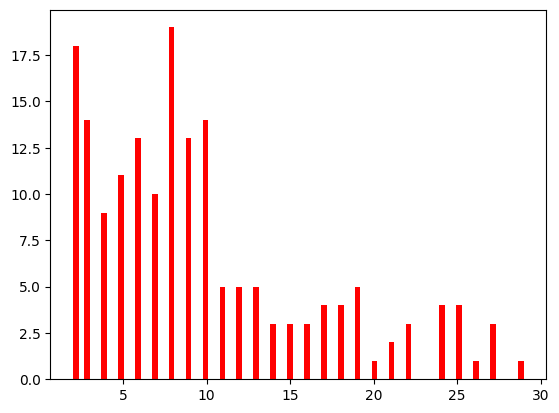

In [108]:
plt.hist(surv1[surv1.event_cause1==1]['duration'], bins=80, color='red',label='esc')

In [128]:
surv2_baseline = surv2[surv2[covariate_name].values.sum(axis=1) == 0]
check_exponential(surv2_baseline['duration'].values, surv2_baseline['event_cause2'].values)

({'KM_median': 7.0,
  'NelsonAalen_H_end': 10.055366105815912,
  'CV_uncensored': 0.7067367204648527,
  'Exp_loglik': -43503.116515822796,
  'Wei_loglik': -41653.53493792063,
  'AIC_exp': 87008.23303164559,
  'AIC_wei': 83311.06987584126,
  'Weibull_shape_rho': 1.5382760705241008,
  'lambda_exp': 8.867382707288568},
 <lifelines.KaplanMeierFitter:"KM_estimate", fitted with 13731 total observations, 61 right-censored observations>,
 <lifelines.NelsonAalenFitter:"NA_estimate", fitted with 13731 total observations, 61 right-censored observations>,
 <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 13731 total observations, 61 right-censored observations>,
 <lifelines.WeibullFitter:"Weibull_estimate", fitted with 13731 total observations, 61 right-censored observations>)

(array([2.845e+03, 2.446e+03, 0.000e+00, 2.541e+03, 0.000e+00, 2.591e+03,
        2.484e+03, 0.000e+00, 2.386e+03, 0.000e+00, 2.266e+03, 1.895e+03,
        0.000e+00, 1.763e+03, 0.000e+00, 1.468e+03, 1.274e+03, 0.000e+00,
        1.047e+03, 0.000e+00, 8.980e+02, 6.810e+02, 0.000e+00, 5.410e+02,
        0.000e+00, 4.720e+02, 3.850e+02, 0.000e+00, 3.250e+02, 0.000e+00,
        2.590e+02, 2.140e+02, 0.000e+00, 1.890e+02, 0.000e+00, 1.360e+02,
        1.270e+02, 0.000e+00, 1.100e+02, 0.000e+00, 8.200e+01, 6.900e+01,
        0.000e+00, 6.500e+01, 0.000e+00, 5.900e+01, 5.400e+01, 0.000e+00,
        4.000e+01, 0.000e+00, 2.800e+01, 2.300e+01, 0.000e+00, 2.600e+01,
        0.000e+00, 2.100e+01, 2.600e+01, 0.000e+00, 1.400e+01, 0.000e+00,
        2.000e+01, 1.000e+01, 0.000e+00, 1.000e+01, 0.000e+00, 9.000e+00,
        6.000e+00, 0.000e+00, 7.000e+00, 0.000e+00, 5.000e+00, 7.000e+00,
        0.000e+00, 1.100e+01, 0.000e+00, 2.000e+00, 3.000e+00, 0.000e+00,
        2.000e+00, 3.000e+00]),
 array

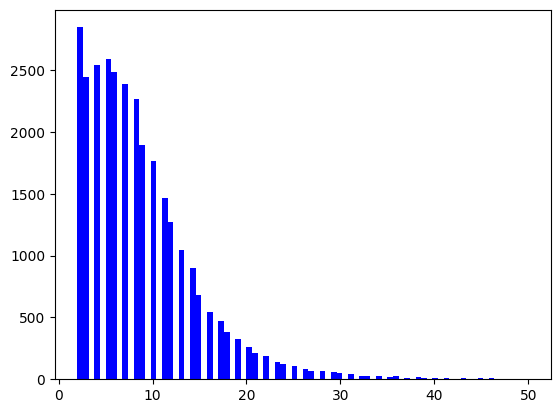

In [79]:
plt.hist(surv2[surv2.event_cause2==1]['duration'], bins=80, color='blue', label='desc')
# plt.hist(surv1[surv1.event_cause1==1]['duration'], bins=80, color='red',label='esc')

safe --> risky

In [39]:
risk_mask = (input._from==3)&(input._to==2) 
risk_duration = input[risk_mask].past.values/5
risk_input = input[risk_mask][covariate_name]
risk_label = np.full(len(risk_mask), 1)

censor_mask = (input._from==3)&(input._to==3)
censor_duration = input[censor_mask].past.values/5
censor_input = input[censor_mask][covariate_name]
censor_label = np.full(len(censor_input), 0)

_duration = np.concatenate([risk_duration, censor_duration])
_event = np.concatenate([risk_label, censor_label])
_covariate = np.concatenate([risk_input, censor_input])
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

# create the survival dataframe
surv3 = pd.DataFrame(data=covariate, columns=covariate_name)
surv3['duration'] = duration
surv3['event'] = np.asarray(event == 1).astype(int)
cph_cs3 = CoxPHFitter()
cph_cs3.fit(surv3, duration_col='duration', event_col='event')
cph_cs3.print_summary()

<lifelines.CoxPHFitter: fitted with 22168 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 22168
number of events observed = 22168
   partial log-likelihood = -199498.47
         time fit was run = 2025-11-11 18:55:29 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
ego_class            0.01      1.01      0.02           -0.04            0.05                0.96                1.05
foe_class            0.08      1.08      0.01            0.05            0.11                1.05                1.11
ego_subjective_risk  0.23      1.26      0.03            0.17            0.30                1.18                1.35
ego_env_risks        0.02      1.02      0.09           -0.15            0.19                0.86                1.21
ramp                 0.29      1.34      0.04            0.20            0.38                1.23                1.46
ego_lc               0.38      1.46      0.04            0.29            0.47                1.34                1.59
foe_lc               0.21      1.24      0.05            0.11            0.32                1.11                1.37
ego_accel           -0.02      0.98      0.02           -0.06            0.02                0.94                1.02
ego_20p_faster       0.12      1.12      0.02            0.08            0.15                1.08                1.17
ego_20p_slower      -0.06      0.94      0.04           -0.14            0.02                0.87                1.02
num_lanes           -0.15      0.86      0.02           -0.20           -0.11                0.82                0.89

                     cmp to     z      p  -log2(p)
covariate                                         
ego_class              0.00  0.21   0.83      0.26
foe_class              0.00  5.70 <0.005     26.33
ego_subjective_risk    0.00  7.14 <0.005     39.98
ego_env_risks          0.00  0.25   0.80      0.31
ramp                   0.00  6.56 <0.005     34.11
ego_lc                 0.00  8.50 <0.005     55.53
foe_lc                 0.00  3.96 <0.005     13.73
ego_accel              0.00 -1.10   0.27      1.88
ego_20p_faster         0.00  6.34 <0.005     32.01
ego_20p_slower         0.00 -1.50   0.13      2.89
num_lanes              0.00 -7.15 <0.005     40.10
---
Concordance = 0.54
Partial AIC = 399018.94
log-likelihood ratio test = 322.88 on 11 df
-log2(p) of ll-ratio test = 205.57

Near-crash dissolve

In [40]:
risk_mask = ((input._from==1)&(input._to==2)) | ((input._from==1)&(input._to==3)) 
risk_duration = input[risk_mask].past.values/5
risk_input = input[risk_mask][covariate_name]
risk_label = np.full(len(risk_mask), 1)

censor_mask = (input._from==1)&(input._to==1)
censor_duration = input[censor_mask].past.values/5
censor_input = input[censor_mask][covariate_name]
censor_label = np.full(len(censor_input), 0)

_duration = np.concatenate([risk_duration, censor_duration])
_event = np.concatenate([risk_label, censor_label])
_covariate = np.concatenate([risk_input, censor_input])
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

# create the survival dataframe
surv4 = pd.DataFrame(data=covariate, columns=covariate_name)
surv4['duration'] = duration
surv4['event'] = np.asarray(event == 1).astype(int)
cph_cs4 = CoxPHFitter()
cph_cs4.fit(surv4, duration_col='duration', event_col='event')
cph_cs4.print_summary()

<lifelines.CoxPHFitter: fitted with 178 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 178
number of events observed = 178
   partial log-likelihood = -719.53
         time fit was run = 2025-11-11 18:55:31 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
ego_class           -0.22      0.81      0.33           -0.87            0.43                0.42                1.54
foe_class            0.27      1.30      0.18           -0.08            0.61                0.92                1.84
ego_subjective_risk  0.94      2.56      0.29            0.36            1.52                1.44                4.57
ego_env_risks       -2.58      0.08      1.12           -4.77           -0.40                0.01                0.67
ramp                 0.49      1.63      0.41           -0.31            1.29                0.74                3.62
ego_lc              -0.10      0.90      0.23           -0.55            0.34                0.58                1.41
foe_lc               0.21      1.24      0.28           -0.33            0.75                0.72                2.12
ego_accel            0.38      1.46      0.10            0.18            0.58                1.19                1.79
ego_20p_faster      -0.10      0.90      0.18           -0.46            0.25                0.63                1.28
ego_20p_slower      -0.67      0.51      0.27           -1.20           -0.14                0.30                0.87
num_lanes            0.17      1.19      0.31           -0.43            0.78                0.65                2.18

                     cmp to     z      p  -log2(p)
covariate                                         
ego_class              0.00 -0.65   0.51      0.96
foe_class              0.00  1.51   0.13      2.92
ego_subjective_risk    0.00  3.19 <0.005      9.47
ego_env_risks          0.00 -2.31   0.02      5.60
ramp                   0.00  1.20   0.23      2.13
ego_lc                 0.00 -0.45   0.65      0.62
foe_lc                 0.00  0.77   0.44      1.18
ego_accel              0.00  3.68 <0.005     12.08
ego_20p_faster         0.00 -0.57   0.57      0.82
ego_20p_slower         0.00 -2.49   0.01      6.28
num_lanes              0.00  0.56   0.58      0.79
---
Concordance = 0.70
Partial AIC = 1461.07
log-likelihood ratio test = 56.67 on 11 df
-log2(p) of ll-ratio test = 24.64

In [41]:
import numpy as np
import pandas as pd

# ------------------------
# 1) Utilities for Cox baselines on an age grid
# ------------------------
def baseline_dH0_on_grid(cph_model, age_grid):
    """
    Safe: ensures H0(0)=0, fills before-first-knot with 0, ffill elsewhere.
    Returns ΔH0 per bin (length K).
    """
    age_grid = pd.Index(np.asarray(age_grid, float))
    H0 = cph_model.baseline_cumulative_hazard_.iloc[:, 0].copy()  # Series

    # Guarantee an explicit zero at age 0
    if 0.0 not in H0.index:
        H0.loc[0.0] = 0.0
    H0 = H0.sort_index()

    # Build a master index and fill: values *before* first knot -> 0; then ffill
    master = H0.index.union(age_grid)
    H0m = H0.reindex(master).sort_index()
    # fill leading NaNs with 0 (no hazard accrued before first event), then forward-fill
    H0m.iloc[0] = H0m.iloc[0] if pd.notna(H0m.iloc[0]) else 0.0
    H0m = H0m.fillna(method="ffill").fillna(0.0)

    # sample exactly on age_grid and take differences
    H0g = H0m.reindex(age_grid)
    dH0 = np.diff(H0g.values)           # length K
    dH0 = np.where(np.isfinite(dH0), dH0, 0.0)
    dH0[dH0 < 0] = 0.0                  # guard
    return dH0


# ------------------------
# 2) Core semi-Markov forward stepper on augmented (state, age-bin) space
# ------------------------
class SemiMarkovCoxForward:
    """
    Three-state example: A, B, C with transitions:
      A->B, B->A, B->C, C->B (you can add more; missing ones are assumed zero)

    Hazards are semi-Markov: λ_{ij}(u | x) = λ0_{ij}(u) * exp(η_{ij}(t, ...)).
    We advance in calendar time with step dt; within each state, sojourn age increases by dt.
    """
    def __init__(self, age_grid, dt,
                 cph_models,
                 eta_funcs):
        """
        age_grid: array of length K+1 defining K bins [u_k, u_{k+1}); dt should equal np.diff(age_grid) if you want 1:1 aging.
        dt: calendar-time step (seconds or whatever matches your model's time unit).
        cph_models: dict keyed by ('A','B'), ('B','A'), ('B','C'), ('C','B') -> lifelines CoxPHFitter models.
        eta_funcs:   dict keyed by same transitions -> callable f(t)-> float (linear predictor).
                     You can close over subject covariates or pass a context if you like (adapt signature if needed).
        """
        self.states = ['A','B','C']
        self.idx = {s:i for i,s in enumerate(self.states)}
        self.dt = float(dt)
        self.age_grid = np.asarray(age_grid, float)             # shape (K+1,)
        self.K = len(self.age_grid) - 1
        if self.K <= 0:
            raise ValueError("age_grid must have at least two points.")
        # Precompute ΔH0 per age bin for each transition
        self.dH0 = {}
        for tr in [('A','B'), ('B','A'), ('B','C'), ('C','B')]:
            if tr in cph_models:
                self.dH0[tr] = baseline_dH0_on_grid(cph_models[tr], self.age_grid)   # shape (K,)
            else:
                self.dH0[tr] = np.zeros(self.K, float)  # absent transition => zero baseline
        self.eta_funcs = {tr: eta_funcs.get(tr, lambda t: 0.0) for tr in self.dH0.keys()}
        # Sanity: if your dt != age step, we still age by the index; set them equal for simplicity.
        step_sizes = np.diff(self.age_grid)
        if not np.allclose(step_sizes, step_sizes[0]):
            raise ValueError("Use an evenly spaced age_grid for this simple implementation.")
        if not np.isclose(step_sizes[0], self.dt):
            print(f"[warn] dt={self.dt} != age bin size={step_sizes[0]}. We will age by bins, not by wall-clock dt.")

    def _lambda_ij_bin(self, tr, t, k):
        """
        Returns the integrated hazard over this step for transition tr on age-bin k:
          Λ_{ij}(bin k at calendar time t) ≈ ΔH0_{ij}[k] * exp(η_{ij}(t))
        This is the 'per-step' jump probability in small-Δt approximation.
        """
        dH0_k = self.dH0[tr][k]            # integrated baseline over this bin [u_k, u_{k+1})
        eta = self.eta_funcs[tr](t)        # linear predictor at calendar time t
        # NOTE: If η should also depend on current state covariates, pass a closure that captures them and updates over time.
        return dH0_k * np.exp(eta)

    def step(self, p_age, t):
        """
        One forward step over dt.
        p_age: array shape (3, K) with probabilities in each (state, age-bin).
        Returns p_age_next (same shape).
        Transition rules from each (i, k):
          - Stays in i and ages to (i, k+1) with prob 1 - sum_j Λ_{ij}(k,t)
          - For each allowed j, jumps to (j, 0) with prob Λ_{ij}(k,t)
        """
        S = len(self.states)
        K = self.K
        p_next = np.zeros_like(p_age)

        # Precompute Λ for each origin state/bin
        # Allowed transitions we consider:
        allowed = {
            'A': [('A','B')],
            'B': [('B','A'), ('B','C')],
            'C': [('C','B')],
        }

        for i, si in enumerate(self.states):
            for k in range(K):
                mass = p_age[i, k]
                if mass == 0.0:
                    continue

                # Compute total outgoing per-step integrated hazards from (si, k)
                L_out = 0.0
                jump_terms = []
                for tr in allowed[si]:
                    L = self._lambda_ij_bin(tr, t, k)
                    if L < 0: L = 0.0
                    jump_terms.append((tr, L))
                    L_out += L

                # (i,k) -> (i,k+1) aging
                if k+1 < K:
                    stay_prob = max(0.0, 1.0 - L_out)
                    p_next[i, k+1] += mass * stay_prob
                else:
                    # last age bin: you may (a) keep it here, (b) reflect to same bin, or (c) treat as "aging cap".
                    stay_prob = max(0.0, 1.0 - L_out)
                    p_next[i, k] += mass * stay_prob

                # Jumps (i,k) -> (j,0)
                for (tr, L) in jump_terms:
                    j = self.idx[tr[1]]
                    p_next[j, 0] += mass * L

        # Normalize tiny numerical drift
        tot = p_next.sum()
        if tot > 0:
            p_next /= tot
        return p_next

    def roll(self, p0_state, T, t0=0.0, return_marginals=True):
        """
        p0_state: initial state distribution over {A,B,C}, shape (3,)
                  (If you know you're in B at t0: [0,1,0])
        T: total forecast horizon (same unit as dt)
        t0: start calendar time (only matters if eta_funcs depend on t)
        return:
          times: array of shape (L+1,)
          p_marg: array (L+1, 3) if return_marginals, else (L+1, 3, K) full age-state distrib
        """
        S, K = 3, self.K
        steps = int(np.round(T / self.dt))
        times = t0 + np.arange(steps+1) * self.dt

        # Initialize age-state distribution: put all mass at age-bin 0 of the starting state(s)
        p_age = np.zeros((S, K), float)
        for i in range(S):
            p_age[i, 0] = p0_state[i]

        traj = []
        traj.append(p_age.copy())
        for n in range(steps):
            t = times[n]
            p_age = self.step(p_age, t)
            traj.append(p_age.copy())

        traj = np.stack(traj, axis=0)  # (steps+1, 3, K)
        if return_marginals:
            p_marg = traj.sum(axis=2)  # sum over age bins -> (steps+1, 3)
            return times, p_marg
        else:
            return times, traj


In [47]:
toy_covariates = np.tile(surv4.to_numpy()[3], (60,1))[:,:-2]

In [52]:
surv4.columns

Index(['ego_class', 'foe_class', 'ego_subjective_risk', 'ego_env_risks',
       'ramp', 'ego_lc', 'foe_lc', 'ego_accel', 'ego_20p_faster',
       'ego_20p_slower', 'num_lanes', 'duration', 'event'],
      dtype='object')

In [51]:
toy_covariates

array([[0.        , 1.        , 0.65107542, 0.16049747, 0.        ,
        1.        , 0.        , 0.20999999, 0.        , 0.        ,
        1.        ],
       [0.        , 1.        , 0.65107542, 0.16049747, 0.        ,
        1.        , 0.        , 0.20999999, 0.        , 0.        ,
        1.        ],
       [0.        , 1.        , 0.65107542, 0.16049747, 0.        ,
        1.        , 0.        , 0.20999999, 0.        , 0.        ,
        1.        ],
       [0.        , 1.        , 0.65107542, 0.16049747, 0.        ,
        1.        , 0.        , 0.20999999, 0.        , 0.        ,
        1.        ],
       [0.        , 1.        , 0.65107542, 0.16049747, 0.        ,
        1.        , 0.        , 0.20999999, 0.        , 0.        ,
        1.        ],
       [0.        , 1.        , 0.65107542, 0.16049747, 0.        ,
        1.        , 0.        , 0.20999999, 0.        , 0.        ,
        1.        ],
       [0.        , 1.        , 0.65107542, 0.16049747, 0.

In [98]:
toy_covariates = np.zeros((12000, 11))

In [105]:
# Age grid and dt (must be evenly spaced for this simple version)
dt = 0.2             # e.g., 0.2 seconds (or whatever your Cox 'duration' unit is)
u_max = 20.0         # maximum sojourn age to track before "capping" the bin
age_grid = np.arange(0.0, u_max + dt, dt)  # length K+1

# Initial condition: at t0 you're in B with prob 1
p0_state = np.array([1.0, 0.0, 0.0])
t0 = 0.0
T = 120.0  # forecast 30 seconds ahead (or same unit as your models)



In [106]:
# Suppose you have lifelines models:
#   cph_AB, cph_BA, cph_BC, cph_CB
cph_models = {
    ('A','B'): cph_cs4,
    ('B','A'): cph_cs2,
    ('B','C'): cph_cs1,
    ('C','B'): cph_cs3,
}

def step_idx(t):
    n = int(round((t - t0) / dt))
    # keep in range
    return max(0, min(n, len(toy_covariates) - 1))

# Define linear predictors (can be constants, or functions of calendar time/context)
# Example 1: subject-specific *constant* covariates (so η is constant).
# You can get η via cph.predict_log_partial_hazard(X_row).item()
eta_funcs = {
    ('A','B'): lambda t: float(np.dot(toy_covariates[step_idx(t)], cph_cs4.params_.values)),  # float you precomputed
    ('B','A'): lambda t: float(np.dot(toy_covariates[step_idx(t)], cph_cs2.params_.values)),
    ('B','C'): lambda t: float(np.dot(toy_covariates[step_idx(t)], cph_cs1.params_.values)),
    ('C','B'): lambda t: float(np.dot(toy_covariates[step_idx(t)], cph_cs3.params_.values)),
}

engine = SemiMarkovCoxForward(age_grid=age_grid, dt=dt,
                              cph_models=cph_models, eta_funcs=eta_funcs)


times, p_of_t = engine.roll(p0_state, T, t0, return_marginals=True)


In [107]:
p_of_t

array([[1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       ...,
       [0.43740084, 0.55855888, 0.00404028],
       [0.43756877, 0.55840603, 0.00402521],
       [0.4369038 , 0.5590128 , 0.0040834 ]])

In [102]:
p_of_t.shape

(151, 3)

Cox-PH Cumulative Incidence Function

In [387]:
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.4.1"
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, numpy2ri, StrVector
import cmprsk

In [371]:
# Activate automatic conversion between pandas DataFrames and R data.frames
numpy2ri.activate()
pandas2ri.activate()

risky --> near-crash

In [388]:
esc_mask = (input._from==2)&(input._to==1)
esc_duration = input[esc_mask].past.values/5
esc_input = input[covariate_name].values[esc_mask]
esc_label = np.full(len(esc_input), 1)

desc_mask = (input._from==2)&(input._to==3)
desc_duration = input[desc_mask].past.values/5
desc_input = input[covariate_name].values[desc_mask]
desc_label = np.full(len(desc_input), 2)

censor_mask = (input._from==2)&(input._to==2)
censor_duration = input[censor_mask].past.values/5
censor_input = input[covariate_name].values[censor_mask]
censor_label = np.full(len(censor_input), 0)

_duration = np.concatenate([esc_duration, desc_duration, censor_duration])
_event = np.concatenate([esc_label, desc_label, censor_label])
_covariate = np.concatenate([esc_input, desc_input, censor_input])
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]


event1 = event
event2 = np.where(event == 1, 2, np.where(event == 2, 1, event))

covariate_name = ['ego_class','foe_class','ego_env_risks','ego_subjective_risk','ramp','_congestion','ego_lc','foe_lc','ego_accel','ego_10p_faster','ego_20p_faster','ego_10p_slower','ego_20p_slower','num_lanes']
DATA = pd.DataFrame(data=covariate, columns=covariate_name)
DATA['duration'] = duration
DATA['event1'] = event1
DATA['event2'] = event2
# Transfer the pandas DataFrame to R’s global environment
robjects.globalenv["data"] = pandas2ri.py2rpy(DATA)
robjects.globalenv["covariate_name"] = StrVector(covariate_name)

In [389]:
# Define and run R code to load cmprsk and fit the Fine–Gray model:
r_code = """
# Load the required library
library(cmprsk)

# Define the covariate matrix (adjust column names as needed)
covariates <- as.matrix(data[, covariate_name])

# Fit the Fine-Gray Model for the event of interest (event code = 1)
fg_model <- crr(ftime = data$duration, fstatus = data$event1, cov1 = covariates)

# Output the summary of the model
summary(fg_model)


"""
# Execute the R code from Python
result = robjects.r(r_code)
# obtained a summary:
fg_summary = robjects.r("summary(fg_model)")
# --- 1. Extract the coefficients matrix from the fg_summary
# This matrix should have one row per covariate and columns: 
#   [coef, exp(coef), se, z, p-value]
fg_coef_matrix = np.array(fg_summary.rx2("coef"))
# For clarity, you can check its shape and column names (if available)
print("Shape of fg_coef_matrix:", fg_coef_matrix.shape)

# --- 2. Retrieve the individual components
# Raw coefficients (log hazard ratios)
coef = fg_coef_matrix[:, 0]

# Hazard Ratios (exp(coef)); should be the same as column 2
hazard_ratios = fg_coef_matrix[:, 1]

# Standard errors (of the coefficients)
se = fg_coef_matrix[:, 2]

# Two-sided p-values
p_values = fg_coef_matrix[:, 4]

# --- 3. Compute 95% Confidence Intervals for the Hazard Ratios
# Lower bound = exp(coef - 1.96*se)
# Upper bound = exp(coef + 1.96*se)
lower_bounds = np.array(fg_summary.rx2("conf.int"))[:,2]
upper_bounds = np.array(fg_summary.rx2("conf.int"))[:,3]

# --- 4. Retrieve Model Fitness Information from 'logtest'
# For many crr models, "logtest" might contain the test statistic and degrees of freedom.
logtest = np.array(fg_summary.rx2("logtest"))
# For example, if logtest has two elements, they may represent [Test Statistic, Degrees of Freedom]
print("Log-test information (model fitness):", logtest)

# --- 5. Check Convergence
# "converged" indicates whether the algorithm converged.
convergence = fg_summary.rx2("converged")[0]
print("Model Convergence:", convergence)

result_summary = pd.DataFrame(
    {"covariate_name": covariate_name, "hazard_ratio": hazard_ratios, "lower_bound": lower_bounds, "upper_bound": upper_bounds, "p_values": p_values}
)
print (result_summary)

Shape of fg_coef_matrix: (14, 5)
Log-test information (model fitness): [283.94415335  14.        ]
Model Convergence: True
         covariate_name  hazard_ratio  lower_bound  upper_bound      p_values
0             ego_class      1.096478     0.744777     1.614261  6.400000e-01
1             foe_class      1.562130     1.290960     1.890260  4.500000e-06
2         ego_env_risks      6.008439     2.046673    17.639033  1.100000e-03
3   ego_subjective_risk      1.783170     1.242994     2.558092  1.700000e-03
4                  ramp      1.868247     1.262534     2.764558  1.800000e-03
5           _congestion      1.743977     1.219879     2.493245  2.300000e-03
6                ego_lc      3.484495     2.765952     4.389702  0.000000e+00
7                foe_lc      3.119649     2.291326     4.247415  5.000000e-13
8             ego_accel      1.306908     1.251160     1.365141  0.000000e+00
9        ego_10p_faster      1.176020     0.930883     1.485711  1.700000e-01
10       ego_20p_fa

risky --> safe

In [391]:
# Define and run R code to load cmprsk and fit the Fine–Gray model:
r_code = """
# Load the required library
library(cmprsk)

# Define the covariate matrix (adjust column names as needed)
covariates <- as.matrix(data[, covariate_name])

# Fit the Fine-Gray Model for the event of interest (event code = 1)
fg_model <- crr(ftime = data$duration, fstatus = data$event2, cov1 = covariates)

# Output the summary of the model
summary(fg_model)
"""
# Execute the R code from Python
result = robjects.r(r_code)
# obtained a summary:
fg_summary = robjects.r("summary(fg_model)")
# --- 1. Extract the coefficients matrix from the fg_summary
# This matrix should have one row per covariate and columns: 
#   [coef, exp(coef), se, z, p-value]
fg_coef_matrix = np.array(fg_summary.rx2("coef"))
# For clarity, you can check its shape and column names (if available)
print("Shape of fg_coef_matrix:", fg_coef_matrix.shape)

# --- 2. Retrieve the individual components
# Raw coefficients (log hazard ratios)
coef = fg_coef_matrix[:, 0]

# Hazard Ratios (exp(coef)); should be the same as column 2
hazard_ratios = fg_coef_matrix[:, 1]

# Standard errors (of the coefficients)
se = fg_coef_matrix[:, 2]

# Two-sided p-values
p_values = fg_coef_matrix[:, 4]

# --- 3. Compute 95% Confidence Intervals for the Hazard Ratios
# Lower bound = exp(coef - 1.96*se)
# Upper bound = exp(coef + 1.96*se)
lower_bounds = np.array(fg_summary.rx2("conf.int"))[:,2]
upper_bounds = np.array(fg_summary.rx2("conf.int"))[:,3]

# --- 4. Retrieve Model Fitness Information from 'logtest'
# For many crr models, "logtest" might contain the test statistic and degrees of freedom.
logtest = np.array(fg_summary.rx2("logtest"))
# For example, if logtest has two elements, they may represent [Test Statistic, Degrees of Freedom]
print("Log-test information (model fitness):", logtest)

# --- 5. Check Convergence
# "converged" indicates whether the algorithm converged.
convergence = fg_summary.rx2("converged")[0]
print("Model Convergence:", convergence)

result_summary = pd.DataFrame(
    {"covariate_name": covariate_name, "hazard_ratio": hazard_ratios, "lower_bound": lower_bounds, "upper_bound": upper_bounds, "p_values": p_values}
)
print (result_summary)

Shape of fg_coef_matrix: (14, 5)
Log-test information (model fitness): [701.70101428  14.        ]
Model Convergence: True
         covariate_name  hazard_ratio  lower_bound  upper_bound      p_values
0             ego_class      1.019952     0.932170     1.116001  6.700000e-01
1             foe_class      1.087140     1.047393     1.128396  1.100000e-05
2         ego_env_risks      0.606521     0.485354     0.757937  1.100000e-05
3   ego_subjective_risk      1.101320     1.008045     1.203227  3.300000e-02
4                  ramp      0.854996     0.765087     0.955469  5.700000e-03
5           _congestion      0.641819     0.599445     0.687189  0.000000e+00
6                ego_lc      0.640505     0.601436     0.682111  0.000000e+00
7                foe_lc      0.721083     0.659375     0.788566  7.800000e-13
8             ego_accel      1.099448     1.017146     1.188409  1.700000e-02
9        ego_10p_faster      0.955961     0.917024     0.996551  3.400000e-02
10       ego_20p_fa

safe --> risky

In [393]:
risk_mask = (input._from==3)&(input._to==2) 
risk_duration = input[risk_mask].past.values/5
risk_input = input[risk_mask][covariate_name]
risk_label = np.full(len(risk_mask), 1)

censor_mask = (input._from==3)&(input._to==3)
censor_duration = input[censor_mask].past.values/5
censor_input = input[censor_mask][covariate_name]
censor_label = np.full(len(censor_input), 0)

_duration = np.concatenate([risk_duration, censor_duration])
_event = np.concatenate([risk_label, censor_label])
_covariate = np.concatenate([risk_input, censor_input])
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

DATA = pd.DataFrame(data=covariate, columns=covariate_name)
DATA['duration'] = duration
DATA['event'] = event

# Transfer the pandas DataFrame to R’s global environment
robjects.globalenv["data_4"] = pandas2ri.py2rpy(DATA)

# Transfer the pandas DataFrame to R’s global environment
robjects.globalenv["data_4"] = pandas2ri.py2rpy(DATA)

# Define and run R code to load cmprsk and fit the Fine–Gray model:
r_code = """
# Load the required library
library(cmprsk)

# Define the covariate matrix (adjust column names as needed)
covariates <- as.matrix(data_4[, covariate_name])

# Fit the Fine-Gray Model for the event of interest (event code = 1)
fg_model_4 <- crr(ftime = data_4$duration, fstatus = data_4$event, cov1 = covariates)

# Output the summary of the model
summary(fg_model_4)
"""
# Execute the R code from Python
result = robjects.r(r_code)
# obtained a summary:
fg_summary_4 = robjects.r("summary(fg_model_4)")

# --- 1. Extract the coefficients matrix from the fg_summary
# This matrix should have one row per covariate and columns: 
#   [coef, exp(coef), se, z, p-value]
fg_coef_matrix_4 = np.array(fg_summary_4.rx2("coef"))
# For clarity, you can check its shape and column names (if available)
print("Shape of fg_coef_matrix:", fg_coef_matrix.shape)

# --- 2. Retrieve the individual components
# Raw coefficients (log hazard ratios)
coef = fg_coef_matrix_4[:, 0]

# Hazard Ratios (exp(coef)); should be the same as column 2
hazard_ratios = fg_coef_matrix_4[:, 1]

# Standard errors (of the coefficients)
se = fg_coef_matrix_4[:, 2]

# Two-sided p-values
p_values = fg_coef_matrix_4[:, 4]

# --- 3. Compute 95% Confidence Intervals for the Hazard Ratios
# Lower bound = exp(coef - 1.96*se)
# Upper bound = exp(coef + 1.96*se)
lower_bounds = np.array(fg_summary_4.rx2("conf.int"))[:,2]
upper_bounds = np.array(fg_summary_4.rx2("conf.int"))[:,3]

# --- 4. Retrieve Model Fitness Information from 'logtest'
# For many crr models, "logtest" might contain the test statistic and degrees of freedom.
logtest = np.array(fg_summary_4.rx2("logtest"))
# For example, if logtest has two elements, they may represent [Test Statistic, Degrees of Freedom]
print("Log-test information (model fitness):", logtest)

# --- 5. Check Convergence
# "converged" indicates whether the algorithm converged.
convergence = fg_summary_4.rx2("converged")[0]
print("Model Convergence:", convergence)

result_summary_4 = pd.DataFrame(
    {"covariate_name": covariate_name, "hazard_ratio": hazard_ratios, "lower_bound": lower_bounds, "upper_bound": upper_bounds, "p_values": p_values}
)


print (result_summary_4)


Shape of fg_coef_matrix: (14, 5)
Log-test information (model fitness): [367.42520913  14.        ]
Model Convergence: True
         covariate_name  hazard_ratio  lower_bound  upper_bound      p_values
0             ego_class      0.992934     0.902524     1.092400  8.800000e-01
1             foe_class      1.143152     1.094159     1.194338  2.100000e-09
2         ego_env_risks      0.798194     0.624470     1.020247  7.200000e-02
3   ego_subjective_risk      1.186003     1.068112     1.316906  1.400000e-03
4                  ramp      1.276299     1.130760     1.440570  7.800000e-05
5           _congestion      0.909881     0.806086     1.027039  1.300000e-01
6                ego_lc      1.934980     1.669062     2.243265  0.000000e+00
7                foe_lc      1.605440     1.358295     1.897554  2.900000e-08
8             ego_accel      0.897202     0.852841     0.943870  2.800000e-05
9        ego_10p_faster      1.173512     1.113565     1.236686  2.200000e-09
10       ego_20p_fa

near-crash --> risky / safe

In [396]:
risk_mask = ((input._from==1)&(input._to==2)) | ((input._from==1)&(input._to==3)) 
risk_duration = input[risk_mask].past.values/5
risk_input = input[risk_mask][covariate_name]
risk_label = np.full(len(risk_mask), 1)

censor_mask = (input._from==1)&(input._to==1)
censor_duration = input[censor_mask].past.values/5
censor_input = input[censor_mask][covariate_name]
censor_label = np.full(len(censor_input), 0)

_duration = np.concatenate([risk_duration, censor_duration])
_event = np.concatenate([risk_label, censor_label])
_covariate = np.concatenate([risk_input, censor_input])
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

DATA = pd.DataFrame(data=covariate, columns=covariate_name)
DATA['duration'] = duration
DATA['event'] = event

# Transfer the pandas DataFrame to R’s global environment
robjects.globalenv["data_3"] = pandas2ri.py2rpy(DATA)

# Transfer the pandas DataFrame to R’s global environment
robjects.globalenv["data_3"] = pandas2ri.py2rpy(DATA)

# Define and run R code to load cmprsk and fit the Fine–Gray model:
r_code = """
# Load the required library
library(cmprsk)

# Define the covariate matrix (adjust column names as needed)
covariates <- as.matrix(data_3[, covariate_name])

# Fit the Fine-Gray Model for the event of interest (event code = 1)
fg_model_3 <- crr(ftime = data_3$duration, fstatus = data_3$event, cov1 = covariates)

# Output the summary of the model
summary(fg_model_3)
"""
# Execute the R code from Python
result = robjects.r(r_code)
# obtained a summary:
fg_summary_3 = robjects.r("summary(fg_model_3)")

# --- 1. Extract the coefficients matrix from the fg_summary
# This matrix should have one row per covariate and columns: 
#   [coef, exp(coef), se, z, p-value]
fg_coef_matrix_3 = np.array(fg_summary_3.rx2("coef"))
# For clarity, you can check its shape and column names (if available)
print("Shape of fg_coef_matrix:", fg_coef_matrix.shape)

# --- 2. Retrieve the individual components
# Raw coefficients (log hazard ratios)
coef = fg_coef_matrix_3[:, 0]

# Hazard Ratios (exp(coef)); should be the same as column 2
hazard_ratios = fg_coef_matrix_3[:, 1]

# Standard errors (of the coefficients)
se = fg_coef_matrix_3[:, 2]

# Two-sided p-values
p_values = fg_coef_matrix_3[:, 4]

# --- 3. Compute 95% Confidence Intervals for the Hazard Ratios
# Lower bound = exp(coef - 1.96*se)
# Upper bound = exp(coef + 1.96*se)
lower_bounds = np.array(fg_summary_3.rx2("conf.int"))[:,2]
upper_bounds = np.array(fg_summary_3.rx2("conf.int"))[:,3]

# --- 4. Retrieve Model Fitness Information from 'logtest'
# For many crr models, "logtest" might contain the test statistic and degrees of freedom.
logtest = np.array(fg_summary_3.rx2("logtest"))
# For example, if logtest has two elements, they may represent [Test Statistic, Degrees of Freedom]
print("Log-test information (model fitness):", logtest)

# --- 5. Check Convergence
# "converged" indicates whether the algorithm converged.
convergence = fg_summary_3.rx2("converged")[0]
print("Model Convergence:", convergence)

result_summary_3 = pd.DataFrame(
    {"covariate_name": covariate_name, "hazard_ratio": hazard_ratios, "lower_bound": lower_bounds, "upper_bound": upper_bounds, "p_values": p_values}
)


print (result_summary_3)


Shape of fg_coef_matrix: (14, 5)
Log-test information (model fitness): [98.85619094 14.        ]
Model Convergence: True
         covariate_name  hazard_ratio  lower_bound  upper_bound      p_values
0             ego_class      0.994738     0.742800     1.332126  9.700000e-01
1             foe_class      0.913398     0.779446     1.070371  2.600000e-01
2         ego_env_risks      0.594517     0.265488     1.331323  2.100000e-01
3   ego_subjective_risk      1.107638     0.867679     1.413957  4.100000e-01
4                  ramp      0.913777     0.681355     1.225482  5.500000e-01
5           _congestion      0.493296     0.366890     0.663255  2.900000e-06
6                ego_lc      0.842531     0.704931     1.006991  6.000000e-02
7                foe_lc      0.989605     0.777738     1.259188  9.300000e-01
8             ego_accel      1.443397     1.255222     1.659783  2.600000e-07
9        ego_10p_faster      1.123663     0.927704     1.361015  2.300000e-01
10       ego_20p_fast

Testing below

In [23]:
warnings.filterwarnings('ignore')
tracks = process_highd_level1(1, distillframeinterval=5, lanechangewindow=25)

In [29]:
data = tracks
batch_size = 32
interactionList = ['precedingId','leftPrecedingId','leftAlongsideId','rightPrecedingId','rightAlongsideId']
num_roles = len(interactionList)

In [ ]:
shockwave_front_mask = np.zeros(tracks.frame.nunique(), dtype=bool)
shockwave_tail_mask = np.zeros(tracks.frame.nunique(), dtype=bool)

for t in range(1, 100+1):
    shockwave_front_mask[:-t] += tracks.groupby('frame').localDensity.mean().values[:-t] - tracks.groupby('frame').localDensity.mean().values[t:] < -5
    shockwave_tail_mask[:-t] += tracks.groupby('frame').localDensity.mean().values[:-t] - tracks.groupby('frame').localDensity.mean().values[t:] > 5

tracks['shockwave_front_mask'] = shockwave_front_mask[tracks['frame'].factorize()[0]]
tracks['shockwave_tail_mask'] = shockwave_tail_mask[tracks['frame'].factorize()[0]]

In [196]:
idx = 4665
frame = 1 + idx*5

In [198]:
shockwave_front_mask[idx]

True

array([ True])

In [120]:
tracks.groupby('frame').localDensity.mean().values[25:]

array([28.38087129, 28.71354662, 28.71354662, ..., 20.48972563,
       19.90306013, 19.32323675])

In [119]:
tracks.groupby('frame').localDensity.mean().values[:-25]

array([23.48696084, 27.76591296, 27.76591296, ..., 19.94422752,
       19.94422752, 19.94422752])

In [117]:
ego_data, foe_data, _indices = get_highd_interaction_pairs(tracks, batch_size=64, return_original_indices=True)

In [183]:
tracks_with_risk = add_risk_to_data(tracks)
# tracks_with_risk = add_ttc_to_data(tracks_with_risk)

100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


In [184]:
risks_data = tracks_with_risk[['precedingSubjectiveRisk', 'followingSubjectiveRisk', 'leftPrecedingSubjectiveRisk', 'leftAlongsideSubjectiveRisk', 'leftFollowingSubjectiveRisk', 'rightPrecedingSubjectiveRisk','rightAlongsideSubjectiveRisk', 'rightFollowingSubjectiveRisk']].values
vehicle_level_risks = 1 - np.prod(1-risks_data, axis=1)
tracks_with_risk['vehicleLevelRisk'] = vehicle_level_risks
tracks_with_risk['meanVehicleLevelRisk'] = (
    tracks_with_risk.groupby(['frame', '_dir'])['vehicleLevelRisk']
    .transform('mean')
)

(array([124785.,  21366.,  14136.,  10746.,   9048.,   7373.,   7067.,
          6272.,   5595.,   5295.,   4296.,   4552.,   3926.,   4174.,
          3628.,   3381.,   3242.,   3100.,   3145.,   2835.,   2710.,
          2564.,   2406.,   2307.,   2306.,   2127.,   2145.,   2076.,
          2086.,   1973.,   1954.,   1940.,   1906.,   1665.,   1623.,
          1583.,   1590.,   1485.,   1444.,   1300.,   1244.,   1383.,
          1314.,   1330.,   1268.,   1221.,   1237.,   1207.,   1087.,
          1001.,   1138.,   1006.,    885.,    868.,    755.,    728.,
           726.,    683.,    763.,    719.,    769.,    711.,    659.,
           691.,    603.,    574.,    530.,    521.,    569.,    452.,
           476.,    446.,    418.,    408.,    391.,    313.,    230.,
           243.,    207.,    296.]),
 array([0.    , 0.0125, 0.025 , 0.0375, 0.05  , 0.0625, 0.075 , 0.0875,
        0.1   , 0.1125, 0.125 , 0.1375, 0.15  , 0.1625, 0.175 , 0.1875,
        0.2   , 0.2125, 0.225 , 0.2375

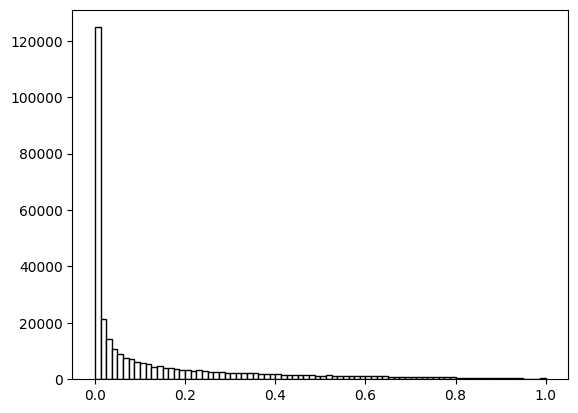

In [185]:
plt.hist(vehicle_level_risks, np.arange(0, 1.0125, 0.0125), ec='black', fc='white')

In [112]:
ego_risk_data, foe_risk_data, _indices = get_highd_interaction_pairs(tracks_with_risk, batch_size=64, return_original_indices=True)

NameError: name 'tracks_with_risk' is not defined

In [187]:
df_ego_risk = pd.DataFrame(ego_risk_data.cpu(), columns=tracks_with_risk.columns)
df_foe_risk = pd.DataFrame(foe_risk_data.cpu(), columns=tracks_with_risk.columns)

In [196]:
get_interaction_recording_2d(df_ego_risk, df_foe_risk)

,ego_vel,foe_vel,ego_accel,foe_accel,ego_pre_left_lc,foe_pre_left_lc,ego_pos_left_lc,foe_pos_left_lc,ego_pre_right_lc,foe_pre_right_lc,...,local_density,local_subjective_risk,ego_length,foe_length,recording_id,ego_id,foe_id,frame,dir,ttc
0,11.14,5.11,-0.33,-0.07,0.0,0.0,0.0,0.0,0.0,0.0,...,23.405033,0.238331,4.75,4.55,0,1.0,2.0,1.0,-1.0,1.000000e+09
1,11.07,5.10,-0.34,-0.07,0.0,0.0,0.0,0.0,0.0,0.0,...,26.830159,0.271509,4.75,4.55,0,1.0,2.0,6.0,-1.0,1.000000e+09
2,11.00,5.08,-0.34,-0.06,0.0,0.0,0.0,0.0,0.0,0.0,...,26.830159,0.279251,4.75,4.55,0,1.0,2.0,11.0,-1.0,1.000000e+09
3,10.94,5.07,-0.35,-0.06,0.0,0.0,0.0,0.0,0.0,0.0,...,26.830159,0.282669,4.75,4.55,0,1.0,2.0,16.0,-1.0,1.000000e+09
4,10.87,5.06,-0.35,-0.06,0.0,0.0,0.0,0.0,0.0,0.0,...,27.401014,0.274542,4.75,4.55,0,1.0,2.0,21.0,-1.0,1.000000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815686,22.63,18.65,-0.82,-3.31,0.0,0.0,0.0,0.0,0.0,0.0,...,25.878735,0.221619,4.65,4.75,0,2708.0,2707.0,28001.0,1.0,1.064720e+01
815687,22.47,23.24,-0.82,-0.22,0.0,0.0,0.0,0.0,0.0,0.0,...,25.117596,0.226359,4.65,6.97,0,2708.0,2705.0,28006.0,1.0,1.000000e+09
815688,22.47,17.98,-0.82,-3.32,0.0,0.0,0.0,0.0,0.0,0.0,...,25.117596,0.226359,4.65,4.75,0,2708.0,2707.0,28006.0,1.0,9.229629e+00
815689,22.30,23.20,-0.82,-0.22,0.0,0.0,0.0,0.0,0.0,0.0,...,24.356457,0.230589,4.65,6.97,0,2708.0,2705.0,28011.0,1.0,1.000000e+09


(array([7.5740e+03, 1.7506e+04, 2.6352e+04, 3.1430e+04, 3.5872e+04,
        4.2391e+04, 5.0246e+04, 3.8228e+04, 2.6817e+04, 2.4435e+04,
        9.3970e+03, 5.1120e+03, 1.2510e+03, 6.0200e+02, 9.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <BarContainer object of 40 artists>)

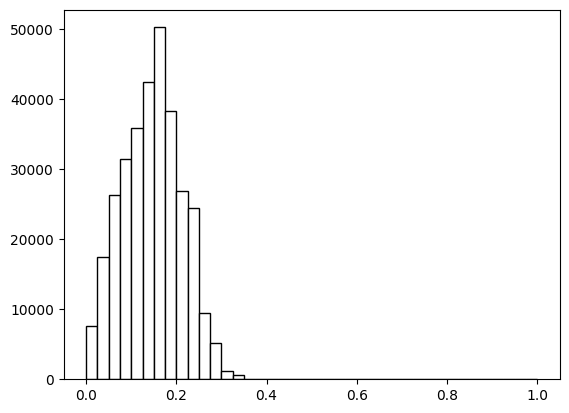

In [155]:
meanRisks = tracks_with_risk.groupby(['frame', '_dir'])['vehicleLevelRisk'].transform('mean').values
plt.hist(meanRisks, np.arange(0, 1.025, 0.025), ec='black', fc='white' )

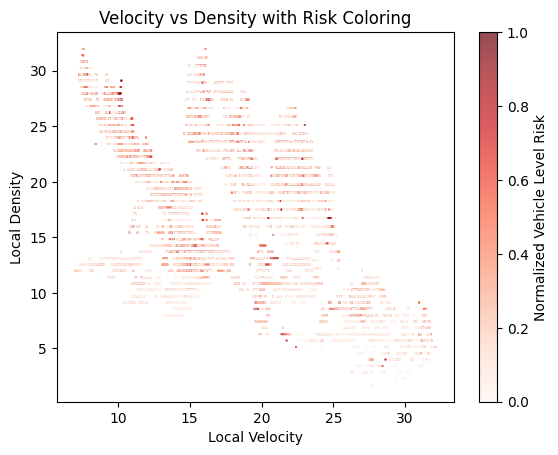

In [166]:
# Normalize risk values for color mapping
risk = tracks_with_risk['vehicleLevelRisk']
norm_risk = (risk - risk.min()) / (risk.max() - risk.min())

# Scatter plot
plt.scatter(
    tracks_with_risk['localVelocity'],
    tracks_with_risk['localDensity'],
    c=norm_risk,
    cmap='Reds',
    alpha=0.7,
    s=0.1
)

plt.xlabel('Local Velocity')
plt.ylabel('Local Density')
plt.title('Velocity vs Density with Risk Coloring')
plt.colorbar(label='Normalized Vehicle Level Risk')
plt.show()

In [39]:
interact_dir = ['precedingId','leftPrecedingId','leftAlongsideId','rightPrecedingId','rightAlongsideId', 'followingId', 'leftFollowingId', 'rightFollowingId']

In [78]:
ego_, foe_, interaction_indices = get_highd_interaction_pairs(tracks, batch_size=64, interactionList=interact_dir, return_original_indices=True)

In [45]:
df_ego = pd.DataFrame(ego_.cpu(), columns=tracks.columns)
df_foe = pd.DataFrame(foe_.cpu(), columns=tracks.columns)

In [41]:

(frame_ids, ego_ids, ego_xs, ego_ys, ego_length, ego_width, ego_xVel, ego_yVel, ego_xAccel, ego_yAccel) = ego_[:,0:10].split(1, dim=1)
(frame_ids, foe_ids, foe_xs, foe_ys, foe_length, foe_width, foe_xVel, foe_yVel, foe_xAccel, foe_yAccel) = foe_[:,0:10].split(1, dim=1)

ego_pos = torch.cat([ego_xs+0.5*ego_length, ego_ys+0.5*ego_width], dim=1)
ego_vel = torch.cat([ego_xVel, ego_yVel], dim=1)
ego_accel = torch.cat([ego_xAccel, ego_yAccel], dim=1)
ego_dim = torch.cat([ego_length, ego_width], dim=1)

foe_pos = torch.cat([foe_xs+0.5*foe_length, foe_ys+0.5*foe_width], dim=1)
foe_vel = torch.cat([foe_xVel, foe_yVel], dim=1)
foe_accel = torch.cat([foe_xAccel, foe_yAccel], dim=1)
foe_dim = torch.cat([foe_length, foe_width], dim=1)

ttcs = get_2D_ttc_circles_cuda_batched(ego_pos, ego_vel, ego_dim, foe_pos, foe_vel, foe_dim, buffer_coef=1.000, bubble=0.2) 

(array([  16.,    6.,    4.,   10.,    8.,    8.,    8.,    8.,   10.,
          14.,   36.,   39.,   49.,   65.,  106.,  100.,  151.,  169.,
         171.,  227.,  277.,  350.,  384.,  469.,  522.,  457.,  594.,
         685.,  776.,  756.,  756.,  799.,  912.,  964.,  982., 1077.,
        1137., 1222., 1183., 1340., 1247., 1262., 1235., 1188., 1272.,
        1306., 1366., 1509., 1389., 1437., 1355., 1456., 1412., 1461.,
        1448., 1472., 1607., 1524., 1528., 1468., 1541., 1492., 1484.,
        1382., 1511., 1599., 1488., 1454., 1503., 1519., 1423., 1463.,
        1545., 1421., 1443., 1455., 1444., 1516., 1326., 1537., 1344.,
        1461., 1359., 1337., 1296., 1320., 1352., 1251., 1262., 1270.,
        1155., 1165., 1237., 1244., 1100., 1122., 1242., 1209., 1115.,
        1126., 1060., 1076., 1098., 1048., 1071., 1020., 1025.,  986.,
         997.,  983.,  974.,  980.,  919.,  967.,  972.,  884.,  897.,
         887.,  930.,  837.,  921.,  778.,  833.,  876.,  802.,  852.,
      

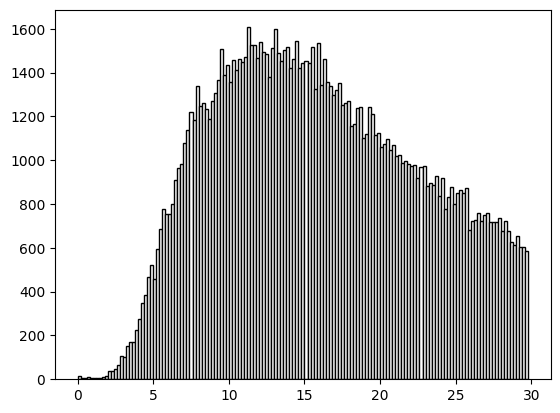

In [25]:
plt.hist(ttcs.cpu(), bins=np.arange(0, 30, 0.2), fc='white', ec='black')

In [46]:
rel_pos = ego_pos - foe_pos
_dx = torch.clamp_min(torch.abs(rel_pos[:,0]) - (ego_dim[:,0]/2 + foe_dim[:,0]/2), 0)
_dy = torch.clamp_min(torch.abs(rel_pos[:,1]) - (ego_dim[:,1]/2 + foe_dim[:,1]/2), 0)
_vel = torch.sqrt(ego_vel[:,0]**2 + ego_vel[:,1]**2)

In [49]:
s_risks = get_subjective_risk(_dx, _dy, _vel)

In [50]:
s_risks.shape

torch.Size([1490631])

(array([4.4236e+04, 2.7462e+04, 2.0569e+04, 1.6086e+04, 1.3125e+04,
        1.1589e+04, 8.9820e+03, 7.9970e+03, 7.6340e+03, 6.1650e+03,
        5.3410e+03, 5.3470e+03, 4.7670e+03, 4.4970e+03, 4.1980e+03,
        3.6530e+03, 3.2560e+03, 3.0090e+03, 2.8580e+03, 2.4590e+03,
        2.4560e+03, 2.3940e+03, 2.3440e+03, 2.1370e+03, 1.9560e+03,
        1.5070e+03, 1.3350e+03, 1.2050e+03, 1.2400e+03, 1.2980e+03,
        1.0980e+03, 8.9000e+02, 8.2200e+02, 7.6800e+02, 7.3700e+02,
        5.9700e+02, 3.4600e+02, 2.9600e+02, 2.2400e+02, 6.0000e+00]),
 array([0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225,
        0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425, 0.45 ,
        0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675,
        0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  ,
        0.925, 0.95 , 0.975, 1.   , 1.025]),
 <BarContainer object of 40 artists>)

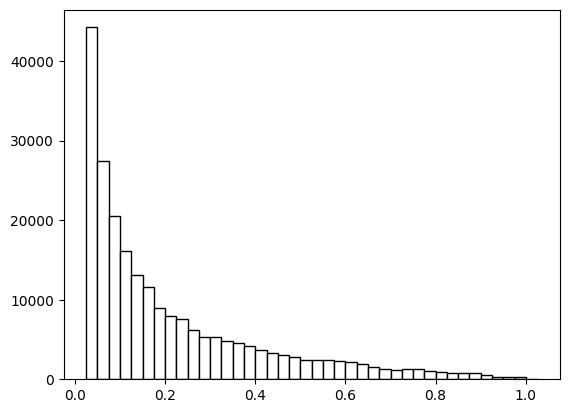

In [55]:
plt.hist(s_risks.cpu(), np.arange(0.025, 1.05, 0.025), fc='white', ec='black')

In [57]:
df_ego['s_risk'] = s_risks.cpu()

In [64]:
df_ego['one_minus_risk'] = 1-s_risks.cpu()

In [66]:
1 - df_ego.groupby(['frame','id']).one_minus_risk.prod()

frame    id    
1.0      1.0       5.185204e-03
         2.0       3.309429e-02
         3.0       1.219873e-03
         4.0       6.198747e-09
         5.0       1.382052e-04
                       ...     
28011.0  2704.0    1.256517e-01
         2705.0    1.653130e-02
         2706.0    3.682549e-02
         2707.0    3.679369e-01
         2708.0    1.665382e-06
Name: one_minus_risk, Length: 317222, dtype: float64

In [46]:
tracks

,frame,id,x,y,width,height,xVelocity,yVelocity,xAcceleration,yAcceleration,...,laneId,_dir,_x,_y,preLeftLaneChange,posLeftLaneChange,preRightLaneChange,posRightLaneChange,localVelocity,localDensity
0,1,1,11.31,12.01,4.75,1.72,-11.14,0.08,0.33,-0.01,...,4,-1,13.685,12.87,0,0,0,0,8.454146,23.405033
5,6,1,9.11,12.02,4.75,1.72,-11.07,0.06,0.34,-0.03,...,4,-1,11.485,12.88,0,0,0,0,8.589149,26.830159
10,11,1,6.86,12.03,4.75,1.72,-11.00,0.04,0.34,-0.04,...,4,-1,9.235,12.89,0,0,0,0,8.561915,26.830159
15,16,1,4.67,12.03,4.75,1.72,-10.94,0.03,0.35,-0.04,...,4,-1,7.045,12.89,0,0,0,0,8.533830,26.830159
20,21,1,2.51,12.03,4.75,1.72,-10.87,0.02,0.35,-0.04,...,4,-1,4.885,12.89,0,0,0,0,8.600625,27.401014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586007,27991,2708,19.09,20.72,4.65,1.92,22.95,0.17,-0.78,-0.02,...,6,1,21.415,21.68,0,0,0,0,15.059118,25.878735
1586012,27996,2708,23.67,20.75,4.65,1.92,22.79,0.16,-0.80,-0.02,...,6,1,25.995,21.71,0,0,0,0,14.981471,25.878735
1586017,28001,2708,28.23,20.78,4.65,1.92,22.63,0.16,-0.82,-0.02,...,6,1,30.555,21.74,0,0,0,0,14.905588,25.878735
1586022,28006,2708,32.73,20.81,4.65,1.92,22.47,0.15,-0.82,-0.02,...,6,1,35.055,21.77,0,0,0,0,14.752727,25.117596
